# Heat Consumption Forecasting Benchmarker
## End-to-End Model Comparison: NHITS vs TimesNet

This notebook provides a comprehensive benchmarking workflow for comparing NHITS and TimesNet models for heat consumption forecasting. It includes:
- Model training and evaluation
- Performance metrics comparison (MAE, RMSE, MAPE, PICP, MIW, CRPS)
- Advanced visualizations
- Reproducible results

**Dataset**: Nordbyen heat consumption data with weather and temporal features  
**Models**: NHITS (Darts) and TimesNet (NeuralForecast)  
**Evaluation**: 50-day walk-forward validation with probabilistic forecasting

## 1. Import Required Libraries
Import all necessary modules for benchmarking, visualization, and data processing.

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display, Image

# Import benchmarker module
from benchmarker import Benchmarker

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully")
print(f"Current working directory: {os.getcwd()}")

/home/hpc/iwi5/iwi5389h/.conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-12-24 09:12:56,552	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-24 09:12:58,196	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


✓ All libraries imported successfully
Current working directory: /home/hpc/iwi5/iwi5389h/ExAI-Timeseries-Thesis


## 2. Configure Benchmark Parameters
Set up paths and parameters for the benchmarking process.

In [3]:
# Data and model paths
DATA_PATH = "nordbyen_processing/nordbyen_features_engineered.csv"
RESULTS_DIR = "results"
MODELS_DIR = "models"

# Models to benchmark - all four variants
MODELS_TO_RUN = ["NHITS_Q", "NHITS_MSE", "TIMESNET_Q", "TIMESNET_MSE"]

# Time periods for training/validation/testing
TRAIN_END = "2018-12-31 23:00:00+00:00"
VAL_END = "2019-12-31 23:00:00+00:00"
TEST_START = "2020-01-01 00:00:00+00:00"

# Verify data file exists
if os.path.exists(DATA_PATH):
    print(f"✓ Data file found: {DATA_PATH}")
    df_info = pd.read_csv(DATA_PATH, nrows=5)
    print(f"  Columns: {list(df_info.columns[:5])}... (total: {len(df_info.columns)})")
else:
    print(f"✗ Data file not found: {DATA_PATH}")
    
# Create results directory if needed
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"✓ Results directory ready: {RESULTS_DIR}")
print(f"✓ Benchmarking models: {MODELS_TO_RUN}")

✓ Data file found: nordbyen_processing/nordbyen_features_engineered.csv
  Columns: ['timestamp', 'heat_consumption', 'temp', 'dew_point', 'humidity']... (total: 27)
✓ Results directory ready: results
✓ Benchmarking models: ['NHITS_Q', 'NHITS_MSE', 'TIMESNET_Q', 'TIMESNET_MSE']


## 3. Run Benchmarker for Both Models

**Two execution options:**
1. **SLURM (Recommended)**: Submit job to HPC cluster - run cells 7A and 7B
2. **Local**: Run directly in notebook - run cell 7C (takes 10-15 minutes)

### Option A: Submit SLURM Job (Recommended)

### Option C: Run Locally (Alternative)

⚠️ **Only use this if you don't want to use SLURM.** This will run in the notebook kernel and may take 10-15 minutes.

### Option B: Monitor SLURM Job Status

Run this cell to check if the benchmarker job is complete. Once complete, proceed to cell 8.

In [30]:
# Submit benchmarker to SLURM
import subprocess
import time

print("Submitting benchmarker job to SLURM...")
print(f"Models to run: {MODELS_TO_RUN}")

# Convert models list to space-separated string for shell argument
models_arg = " ".join(MODELS_TO_RUN)

result = subprocess.run(
    ["sbatch", "benchmark_job.slurm", models_arg],
    capture_output=True,
    text=True
)

if result.returncode == 0:
    # Extract job ID from output: "Submitted batch job 123456"
    job_id = result.stdout.strip().split()[-1]
    print(f"✓ Job submitted successfully!")
    print(f"  Job ID: {job_id}")
    print(f"  Models: {', '.join(MODELS_TO_RUN)}")
    print(f"  Log files: benchmark_{job_id}.log / benchmark_{job_id}.err")
    print(f"\n💡 Next: Run cell 7B to monitor job status")
    
    # Save job ID for monitoring
    with open("current_job_id.txt", "w") as f:
        f.write(job_id)
else:
    print(f"✗ Error submitting job:\n{result.stderr}")

Submitting benchmarker job to SLURM...
Models to run: ['NHITS_Q', 'NHITS_MSE', 'TIMESNET_Q', 'TIMESNET_MSE']
✓ Job submitted successfully!
  Job ID: 1473003
  Models: NHITS_Q, NHITS_MSE, TIMESNET_Q, TIMESNET_MSE
  Log files: benchmark_1473003.log / benchmark_1473003.err

💡 Next: Run cell 7B to monitor job status


## 4.1 View Benchmark History
Track improvements over multiple runs to see if your changes are helping.

📊 BENCHMARK HISTORY - ALL RUNS
Total runs recorded: 6
Models tracked: NHITS_Q, NHITS_MSE, TIMESNET_Q, TIMESNET_MSE



run_date         Model  n_epochs  has_hpo       MAE      RMSE  \
2  2025-12-24 01:27:40       NHITS_Q       100     True  0.194379  0.256022   
3  2025-12-24 01:27:40     NHITS_MSE       100    False  0.222594  0.289575   
4  2025-12-24 01:27:40    TIMESNET_Q       150     True  0.216718  0.280244   
5  2025-12-24 01:27:40  TIMESNET_MSE       150    False  0.283561  0.363079   
0  2025-12-22 01:56:06       NHITS_Q         2     True  0.238634  0.298465   
1  2025-12-22 01:56:06     NHITS_MSE         2    False  0.250765  0.315765   

       MAPE      CRPS  
2  5.958039  0.207927  
3  6.835031       NaN  
4  6.599165  0.188942  
5  8.578925       NaN  
0  7.105164  0.331828  
1  7.378100       NaN


📈 METRIC TRENDS OVER TIME


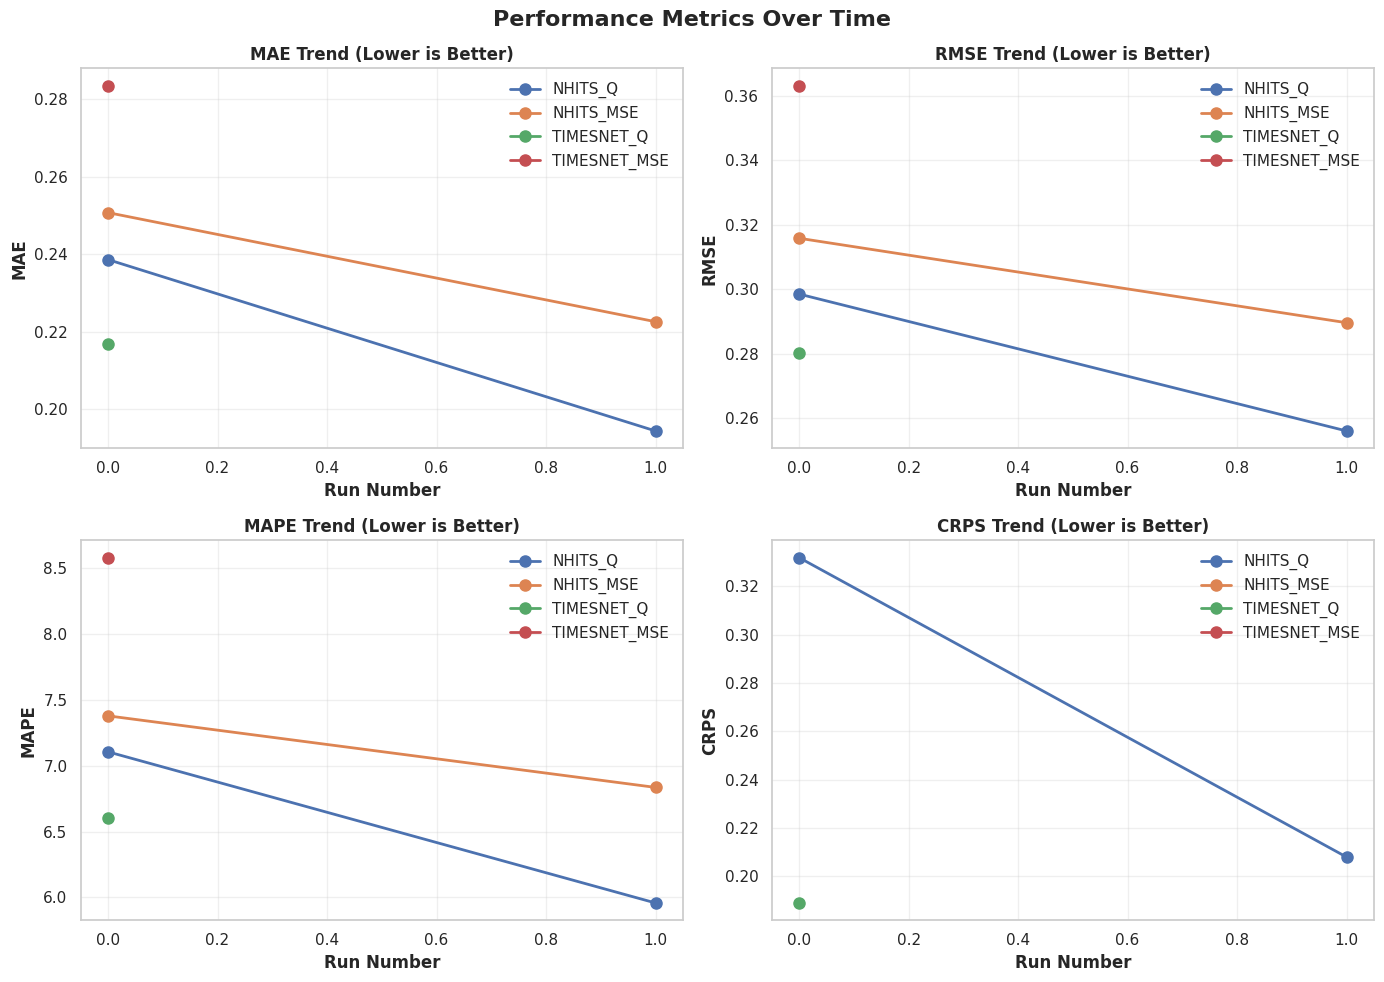


✓ Trend plot saved to: results/benchmark_history_trends.png

🏆 BEST RESULTS EVER ACHIEVED

NHITS_Q:
  MAE     : 0.1944 (achieved on 2025-12-24 01:27:40)
  RMSE    : 0.2560 (achieved on 2025-12-24 01:27:40)
  MAPE    : 5.9580 (achieved on 2025-12-24 01:27:40)
  CRPS    : 0.2079 (achieved on 2025-12-24 01:27:40)

NHITS_MSE:
  MAE     : 0.2226 (achieved on 2025-12-24 01:27:40)
  RMSE    : 0.2896 (achieved on 2025-12-24 01:27:40)
  MAPE    : 6.8350 (achieved on 2025-12-24 01:27:40)


/tmp/ipykernel_3932104/2632992897.py:53: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  best_idx = model_history[metric].idxmin()


KeyError: nan

In [8]:
# View benchmark history across all runs
history_file = os.path.join(RESULTS_DIR, "benchmark_history.csv")

if os.path.exists(history_file):
    history = pd.read_csv(history_file)
    
    print("📊 BENCHMARK HISTORY - ALL RUNS")
    print("="*70)
    print(f"Total runs recorded: {len(history)}")
    print(f"Models tracked: {', '.join(history['Model'].unique())}")
    print("\n" + "="*70)
    
    # Show all runs with key metrics
    display_cols = ['run_date', 'Model', 'n_epochs', 'has_hpo', 'MAE', 'RMSE', 'MAPE', 'CRPS']
    available_cols = [col for col in display_cols if col in history.columns]
    display(history[available_cols].sort_values('run_date', ascending=False))
    
    # Plot improvement trends
    print("\n📈 METRIC TRENDS OVER TIME")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Performance Metrics Over Time', fontsize=16, fontweight='bold')
    
    metrics = ['MAE', 'RMSE', 'MAPE', 'CRPS']
    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        for model in history['Model'].unique():
            model_data = history[history['Model'] == model].sort_values('run_date')
            if metric in model_data.columns:
                ax.plot(range(len(model_data)), model_data[metric], 
                       marker='o', label=model, linewidth=2, markersize=8)
        
        ax.set_xlabel('Run Number', fontweight='bold')
        ax.set_ylabel(metric, fontweight='bold')
        ax.set_title(f'{metric} Trend (Lower is Better)', fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'benchmark_history_trends.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Trend plot saved to: {os.path.join(RESULTS_DIR, 'benchmark_history_trends.png')}")
    
    # Show best results ever
    print("\n🏆 BEST RESULTS EVER ACHIEVED")
    print("="*70)
    for model in history['Model'].unique():
        model_history = history[history['Model'] == model]
        print(f"\n{model}:")
        for metric in ['MAE', 'RMSE', 'MAPE', 'CRPS']:
            if metric in model_history.columns:
                best_idx = model_history[metric].idxmin()
                best_val = model_history.loc[best_idx, metric]
                best_date = model_history.loc[best_idx, 'run_date']
                print(f"  {metric:8s}: {best_val:.4f} (achieved on {best_date})")
else:
    print("❌ No benchmark history found yet.")
    print(f"   Expected file: {history_file}")
    print("\n💡 Run a benchmark first to start tracking results.")

In [9]:
# Check SLURM job status
import subprocess
import os
from datetime import datetime

# Get job ID
if os.path.exists("current_job_id.txt"):
    with open("current_job_id.txt", "r") as f:
        job_id = f.read().strip()
else:
    print("❌ No job ID found. Run cell 7A first to submit the job.")
    job_id = None


if job_id:
    print(f"Checking status of Job {job_id}...")
    print("="*70)
    
    # Check with squeue
    result = subprocess.run(
        ["squeue", "-j", job_id, "--format=%.18i %.9P %.20j %.8u %.8T %.10M %.9l %.6D %R"],
        capture_output=True,
        text=True
    )
    
    if "Invalid job id" in result.stderr or not result.stdout.strip().split('\n')[1:]:
        print(f"⏹️  Job {job_id} is no longer in queue (completed or failed)")
        
        # Check if results exist
        results_file = os.path.join(RESULTS_DIR, "benchmark_results.csv")
        if os.path.exists(results_file):
            print(f"\n✅ Job completed successfully!")
            print(f"   Results file found: {results_file}")
            print(f"\n💡 Next: Continue to cell 8 to view results")
        else:
            print(f"\n❌ Job completed but results not found!")
            print(f"   Check log files: benchmark_{job_id}.log / benchmark_{job_id}.err")
    else:
        print(result.stdout)
        print(f"\n⏳ Job is still running. Re-run this cell to check again.")
        print(f"   Estimated time: 10-15 minutes total")
        
    # Show recent log output
    log_file = f"benchmark_{job_id}.log"
    if os.path.exists(log_file):
        print(f"\n📄 Recent log output (last 15 lines):")
        print("-"*70)
        result = subprocess.run(["tail", "-n", "15", log_file], capture_output=True, text=True)
        print(result.stdout)

Checking status of Job 1472954...
⏹️  Job 1472954 is no longer in queue (completed or failed)

✅ Job completed successfully!
   Results file found: results/benchmark_results.csv

💡 Next: Continue to cell 8 to view results

📄 Recent log output (last 15 lines):
----------------------------------------------------------------------
= Elapsed runtime    : 07:36:48
= Total RAM usage    : 3.4 GiB of requested  GiB (%)   
= Node list          : tg096
= Subm/Elig/Start/End: 2025-12-23T15:08:11 / 2025-12-23T15:08:11 / 2025-12-23T17:51:01 / 2025-12-24T01:27:49
=== Quota infos ======
    Path                 Used     SoftQ    HardQ    Gracetime  Filec    FileQ    FiHaQ    FileGrace    
    /home/hpc              61.6G   104.9G   209.7G        N/A     203K     500K   1,000K        N/A    
    /home/woody           171.0M  1000.0G  1500.0G        N/A   9,028    5,000K   7,500K        N/A    
    /home/vault             0.0K  1048.6G  2097.2G        N/A       1      200K     400K        N/A    
=== 

### Option C: Run Locally (Alternative)

⚠️ **Only use this if you don't want to use SLURM.** This will run in the notebook kernel and may take 10-15 minutes.

In [10]:
# # LOCAL EXECUTION - Run benchmarker directly in notebook
# print("="*70)
# print("Starting Benchmark Pipeline (LOCAL EXECUTION)")
# print("="*70)
# print("\n⚠️  This will take 10-15 minutes and may timeout")
# print("    - NHITS: ~2-3 minutes (15 epochs)")
# print("    - TimesNet: ~3-5 minutes (50 epochs)")
# print("\n💡 RECOMMENDED: Use SLURM instead (cells 7A & 7B)")
# print("="*70 + "\n")

# benchmarker = Benchmarker(DATA_PATH, MODELS_TO_RUN)
# benchmarker.run()

# print("\n" + "="*70)
# print("Benchmark Complete!")
# print("="*70)

## 4. Display Benchmark Results
Load and display the comprehensive metrics comparison.

In [15]:
# Load and display results
results_file = os.path.join(RESULTS_DIR, "benchmark_results.csv")

if not os.path.exists(results_file):
    print("❌ ERROR: Benchmark results not found!")
    print(f"   Expected file: {results_file}")
    print("\n💡 Solution:")
    print("   - If using SLURM: Check cell 7B to see if job is still running")
    print("   - If using local: Run cell 7C first to execute the benchmarker")
else:
    results_df = pd.read_csv(results_file)
    
    print("\n📊 BENCHMARK RESULTS SUMMARY")
    print("="*70)
    display(results_df)
    
    # Highlight best performer for each metric
    print("\n🏆 Best Performer by Metric:")
    for metric in ['MAE', 'RMSE', 'MAPE', 'MIW', 'CRPS']:
        if metric in results_df.columns:
            best_model = results_df.loc[results_df[metric].idxmin(), 'Model']
            best_value = results_df[metric].min()
            print(f"  {metric:8s}: {best_model:10s} ({best_value:.4f})")
    
    # For PICP, higher is better (should be close to 80% for 80% prediction interval)
    if 'PICP' in results_df.columns:
        target_picp = 80.0
        results_df['PICP_diff'] = (results_df['PICP'] - target_picp).abs()
        best_model = results_df.loc[results_df['PICP_diff'].idxmin(), 'Model']
        best_value = results_df.loc[results_df['PICP_diff'].idxmin(), 'PICP']
        print(f"  PICP    : {best_model:10s} ({best_value:.2f}% - closest to 80%)")


📊 BENCHMARK RESULTS SUMMARY


MAE      RMSE      MAPE       PICP       MIW      CRPS         Model
0  0.194379  0.256022  5.958039  41.833333  0.248245  0.207927       NHITS_Q
1  0.222594  0.289575  6.835031        NaN       NaN       NaN     NHITS_MSE
2  0.216718  0.280244  6.599165  19.500000  0.145866  0.188942    TIMESNET_Q
3  0.283561  0.363079  8.578925        NaN       NaN       NaN  TIMESNET_MSE


🏆 Best Performer by Metric:
  MAE     : NHITS_Q    (0.1944)
  RMSE    : NHITS_Q    (0.2560)
  MAPE    : NHITS_Q    (5.9580)
  MIW     : TIMESNET_Q (0.1459)
  CRPS    : TIMESNET_Q (0.1889)
  PICP    : NHITS_Q    (41.83% - closest to 80%)


## 5. Generate Visualizations
Create comprehensive visualizations comparing both models.

### 5.4 Training & Validation Loss Curves
Visualize the per-epoch training and validation loss for both models (from Lightning logs).

Plotting loss curves from Lightning logs...
Saved loss curves to results/loss_curves.png



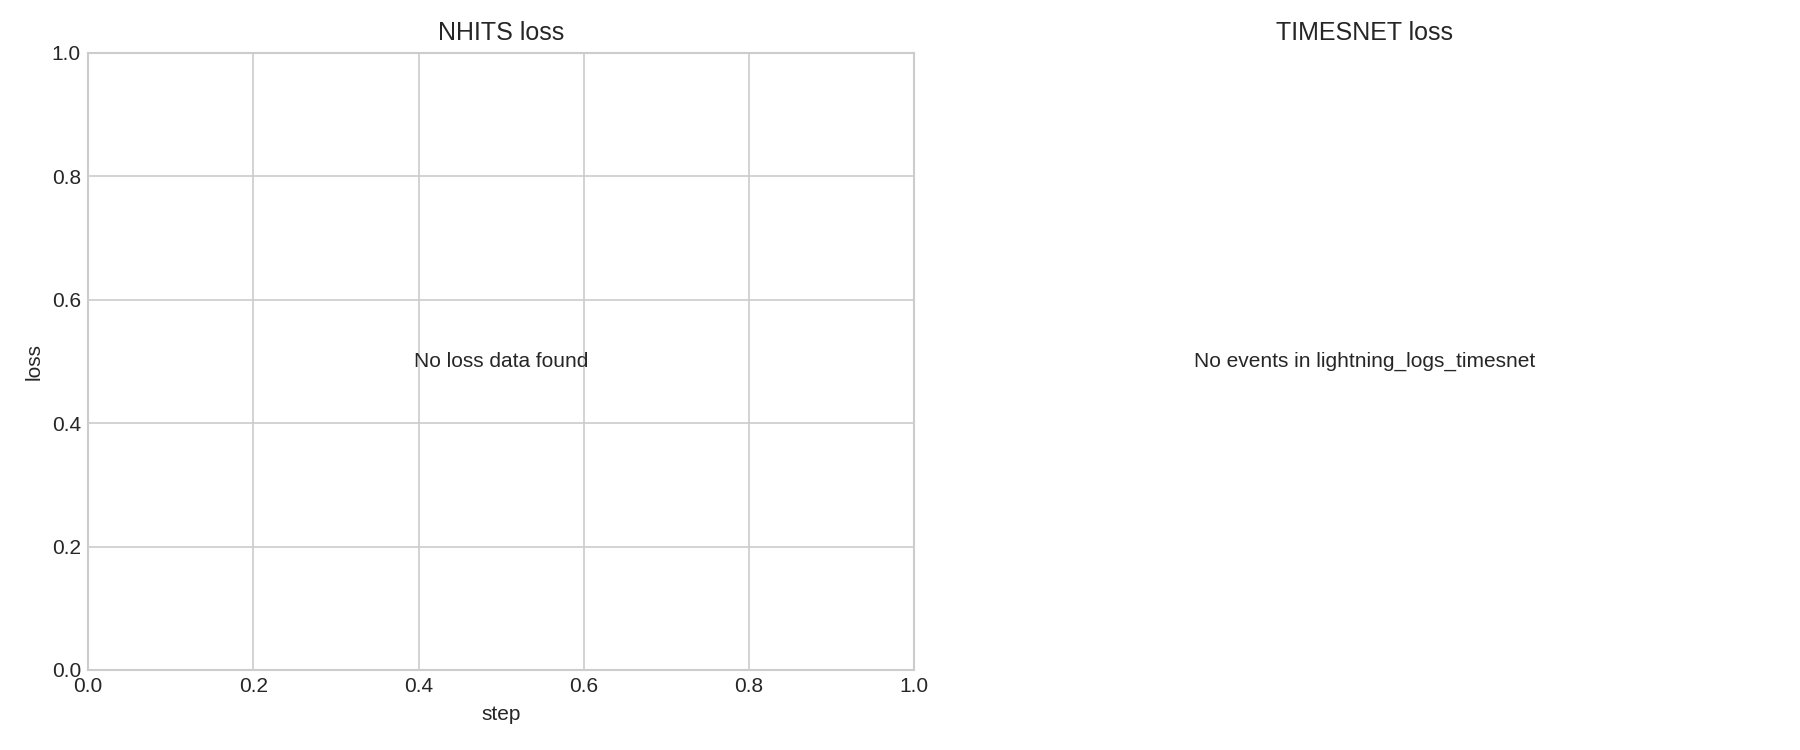

In [16]:
# Plot and display training/validation loss curves
import subprocess
from IPython.display import Image, display

print("Plotting loss curves from Lightning logs...")
result = subprocess.run(["python3", "plot_losses.py"], capture_output=True, text=True)
print(result.stdout)

loss_plot = "results/loss_curves.png"
if os.path.exists(loss_plot):
    display(Image(filename=loss_plot))
else:
    print(f"Loss plot not found: {loss_plot}")

In [17]:
# Run visualization script
print("Generating visualizations...")
import subprocess
result = subprocess.run(
    ["python3", "visualize_benchmark.py"],
    capture_output=True,
    text=True
)
print(result.stdout)
if result.returncode == 0:
    print("✓ Visualizations generated successfully!")
else:
    print(f"✗ Error generating visualizations:\n{result.stderr}")

Generating visualizations...

Model Comparison Metrics:
                MAE   RMSE   MAPE  PICP    MIW   CRPS
NHITS_Q       0.199  0.259  6.067  40.0  0.250  0.160
TIMESNET_Q    0.217  0.280  6.599  19.5  0.146  0.189
NHITS_MSE     0.218  0.284  6.589   0.0  0.000  0.218
TIMESNET_MSE  0.284  0.363  8.579   0.0  0.000  0.284
Bar plots for metrics saved to results/benchmark_metrics_barplots.png
Box plots for predictions saved to results/benchmark_boxplots.png
Side-by-side comparison plot saved to results/benchmark_comparison_sidebyside.png
Figure(1500x500)

✓ Visualizations generated successfully!


### 5.1 Metrics Comparison Bar Plots
Compare all 6 metrics (MAE, RMSE, MAPE, PICP, MIW, CRPS) across both models.

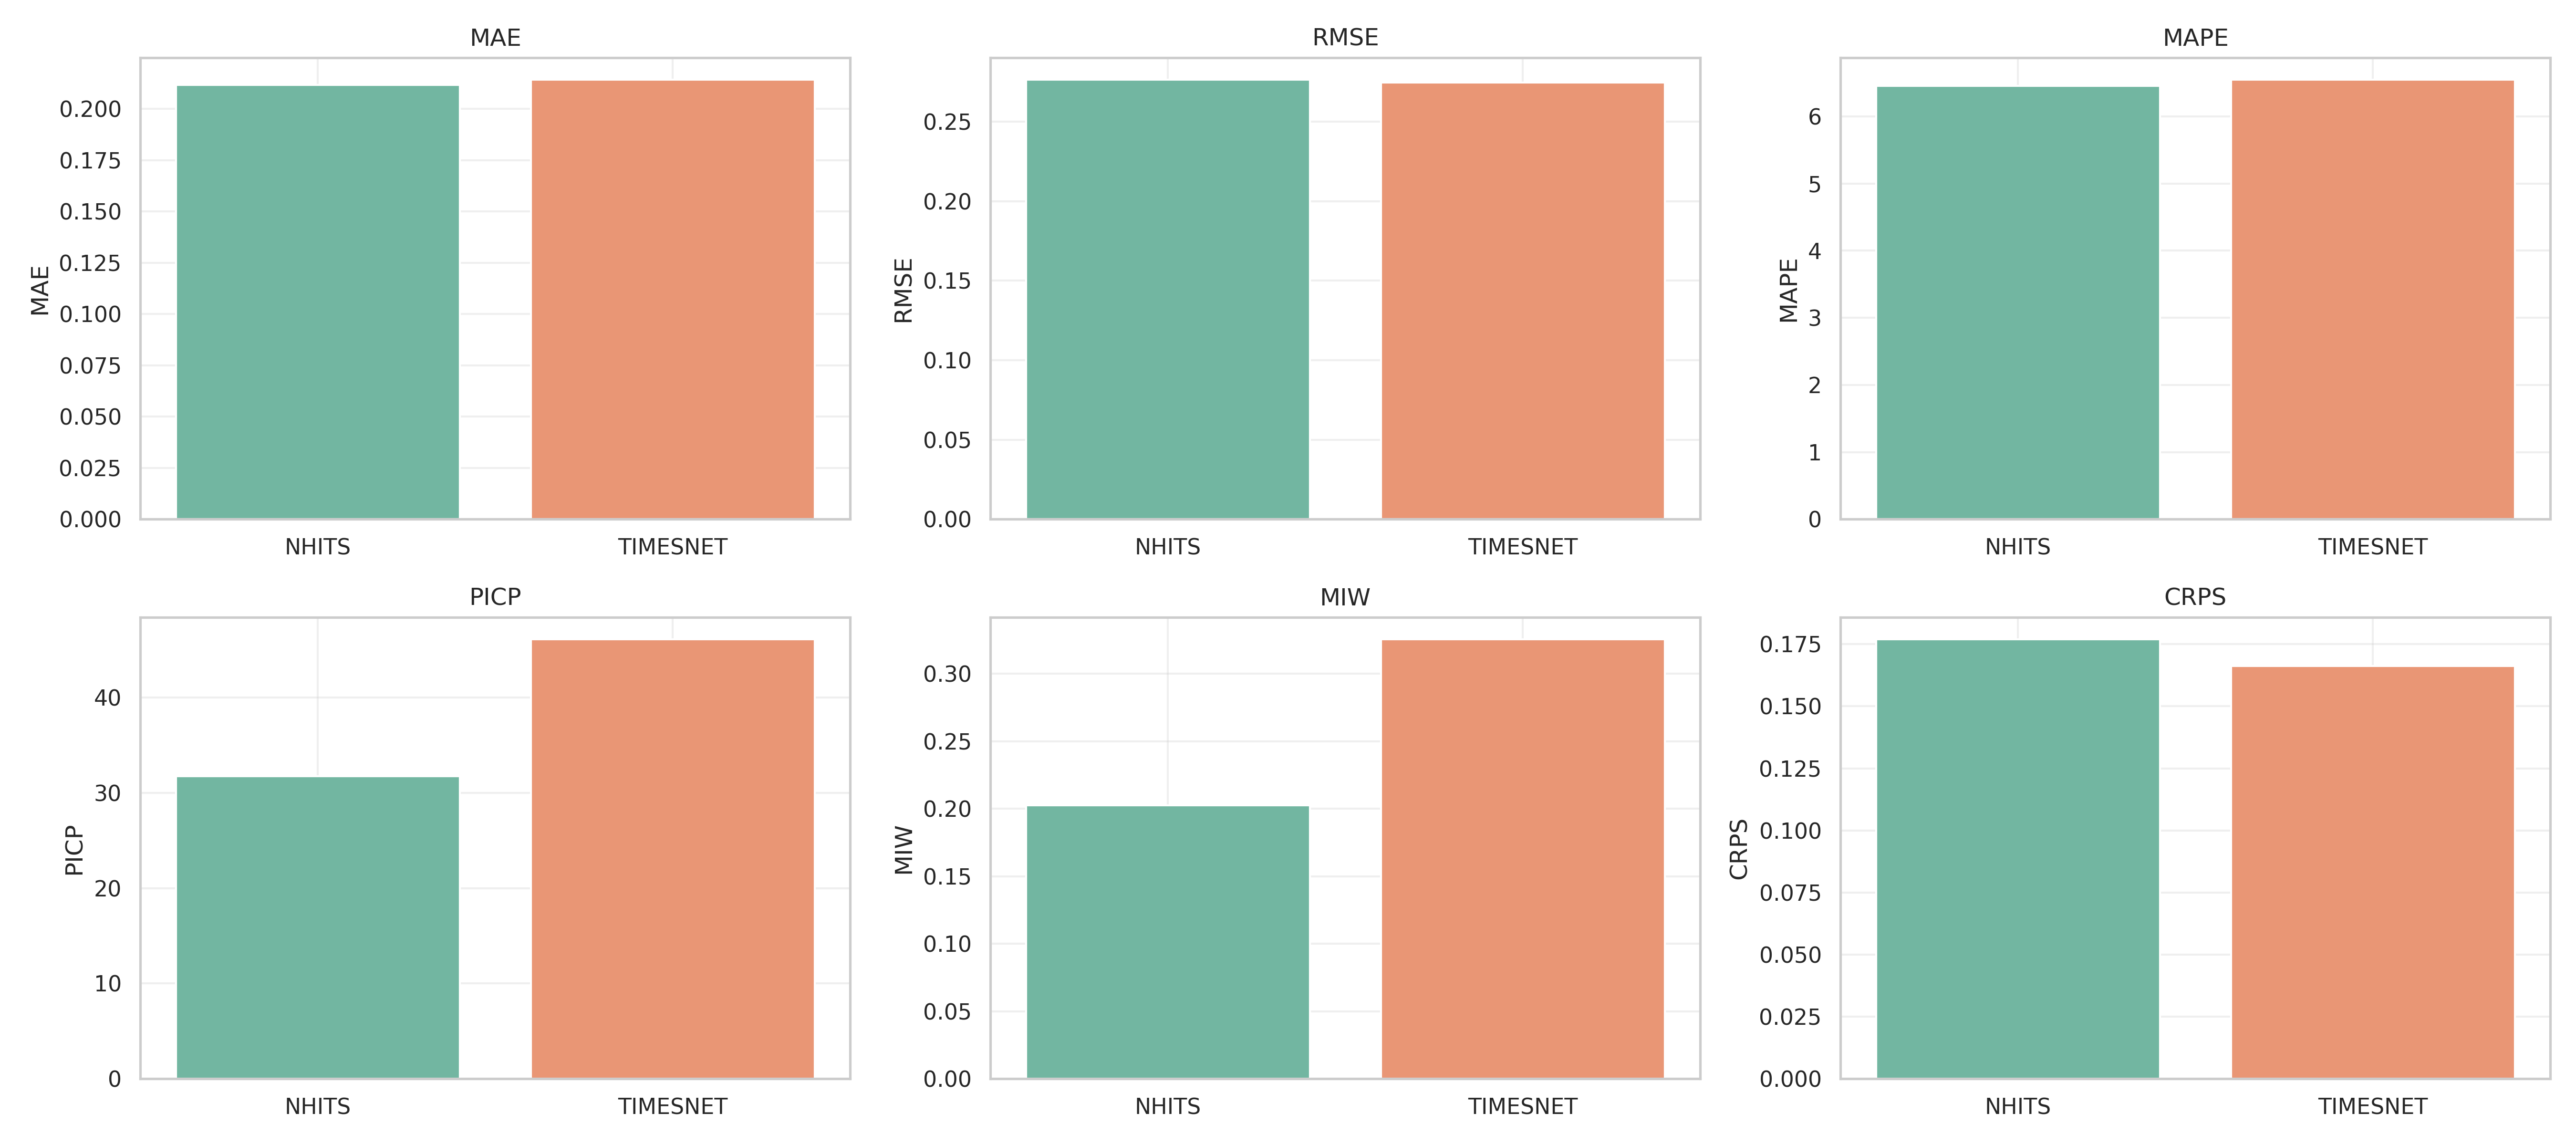

In [14]:
metrics_plot = os.path.join(RESULTS_DIR, "benchmark_metrics_barplots.png")
if os.path.exists(metrics_plot):
    display(Image(filename=metrics_plot))
else:
    print(f"Plot not found: {metrics_plot}")

### 5.2 Box Plots - Prediction Distributions
Compare the distribution of actual values and predictions (p10, p50, p90) for both models.

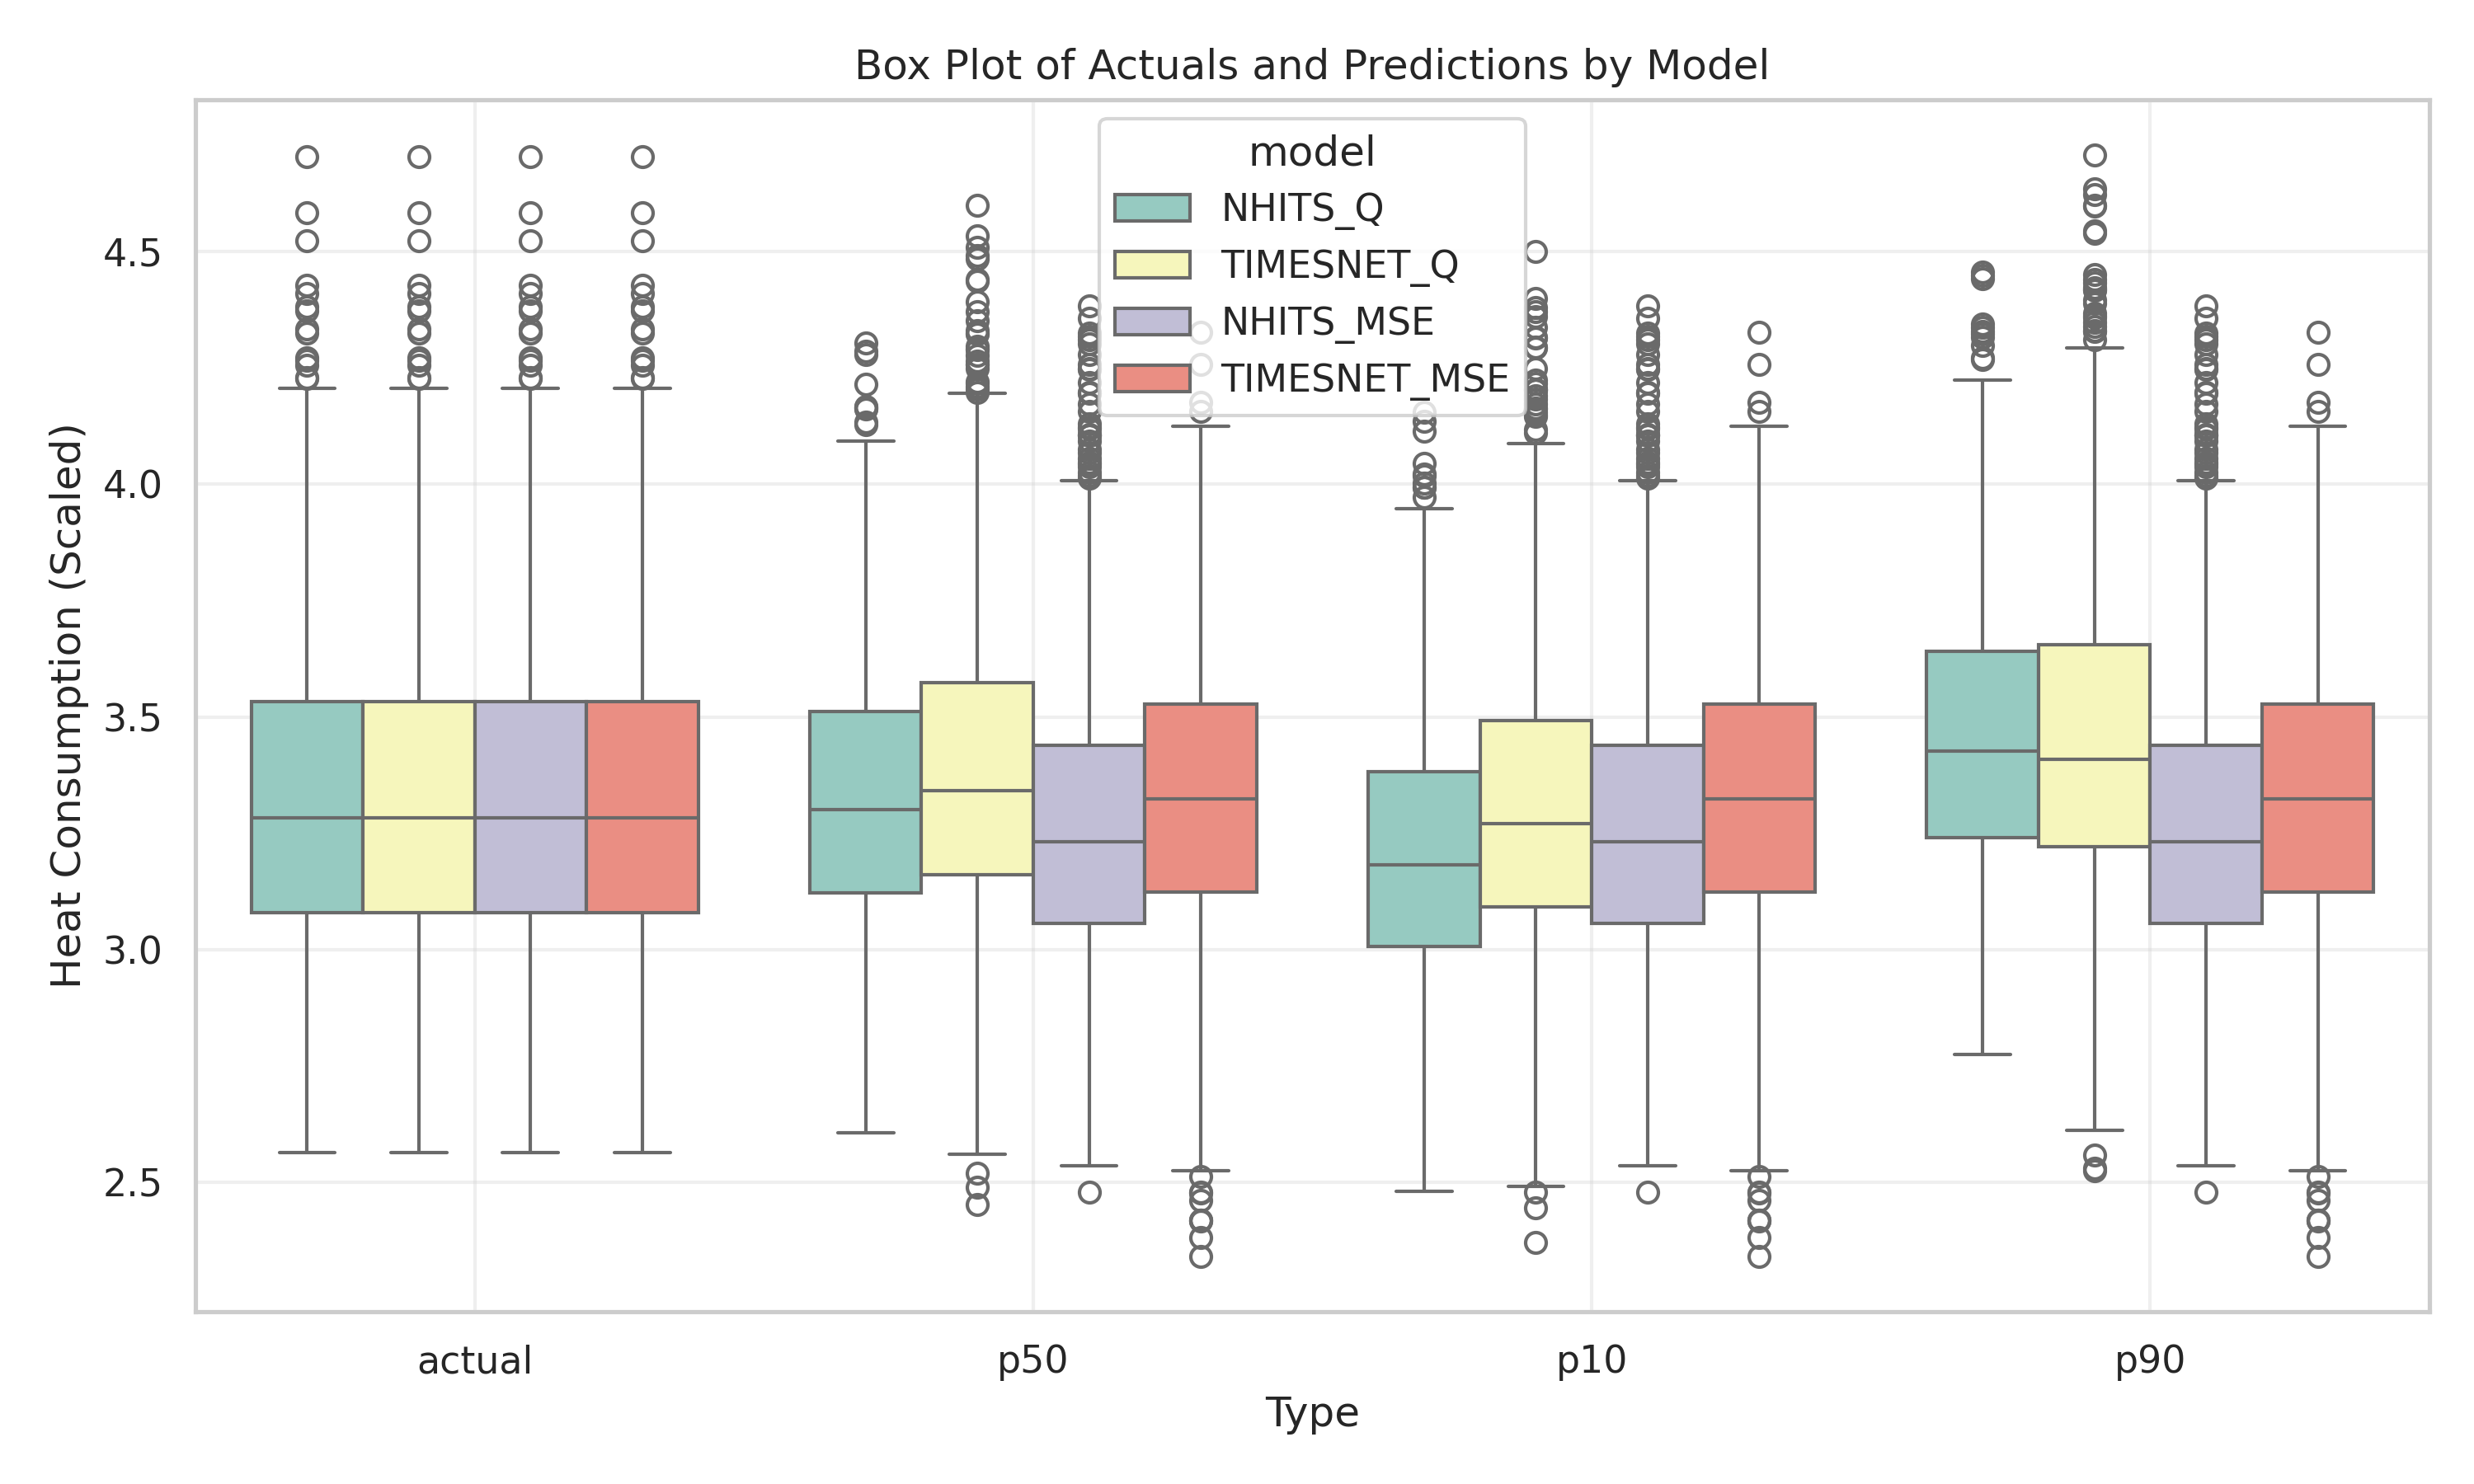

In [18]:
boxplot_img = os.path.join(RESULTS_DIR, "benchmark_boxplots.png")
if os.path.exists(boxplot_img):
    display(Image(filename=boxplot_img))
else:
    print(f"Plot not found: {boxplot_img}")

### 5.3 Side-by-Side Time Series Comparison
Visual comparison of forecast quality over the first 7 days of testing.

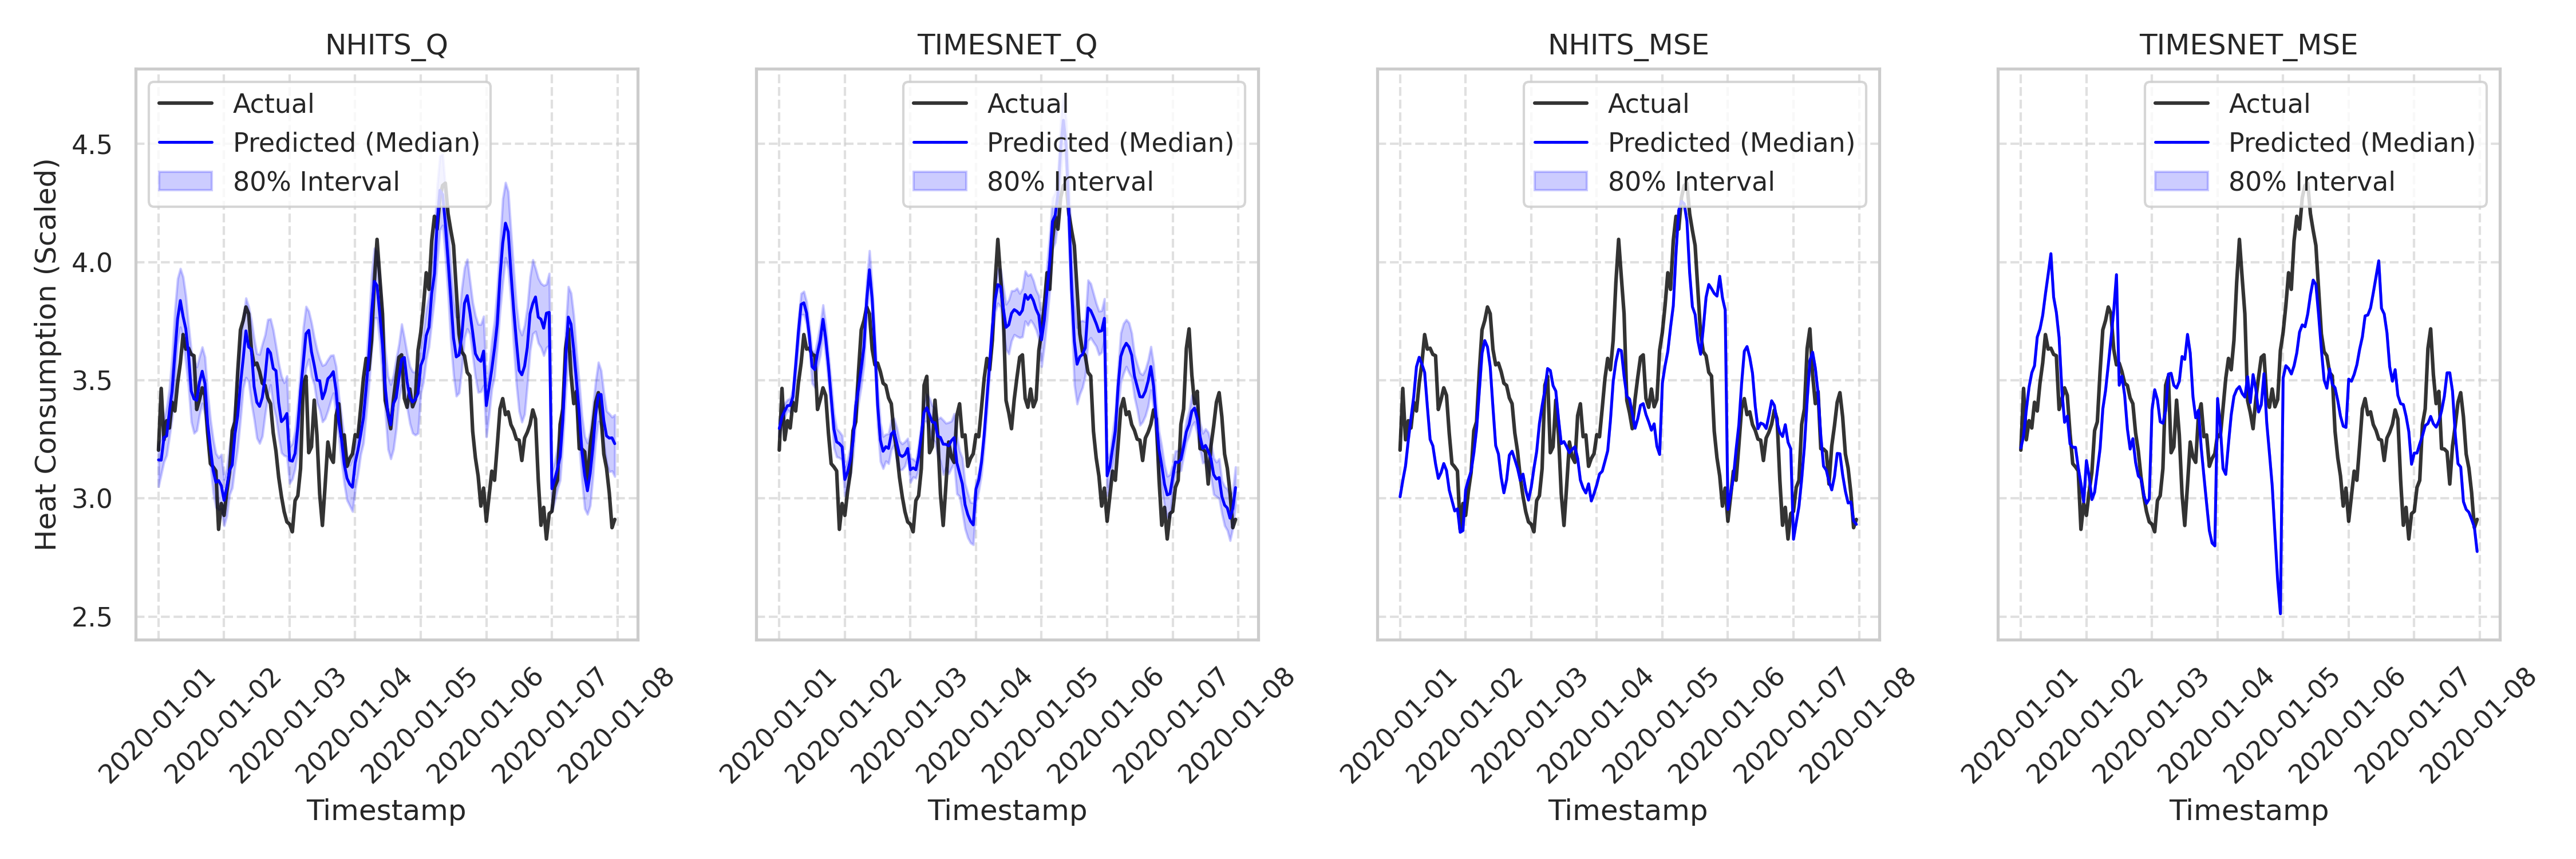

In [19]:
sidebyside_img = os.path.join(RESULTS_DIR, "benchmark_comparison_sidebyside.png")
if os.path.exists(sidebyside_img):
    display(Image(filename=sidebyside_img))
else:
    print(f"Plot not found: {sidebyside_img}")

## 6. Individual Model Visualizations

### 6.1 NHITS Model Analysis

NHITS - Time Series Forecast


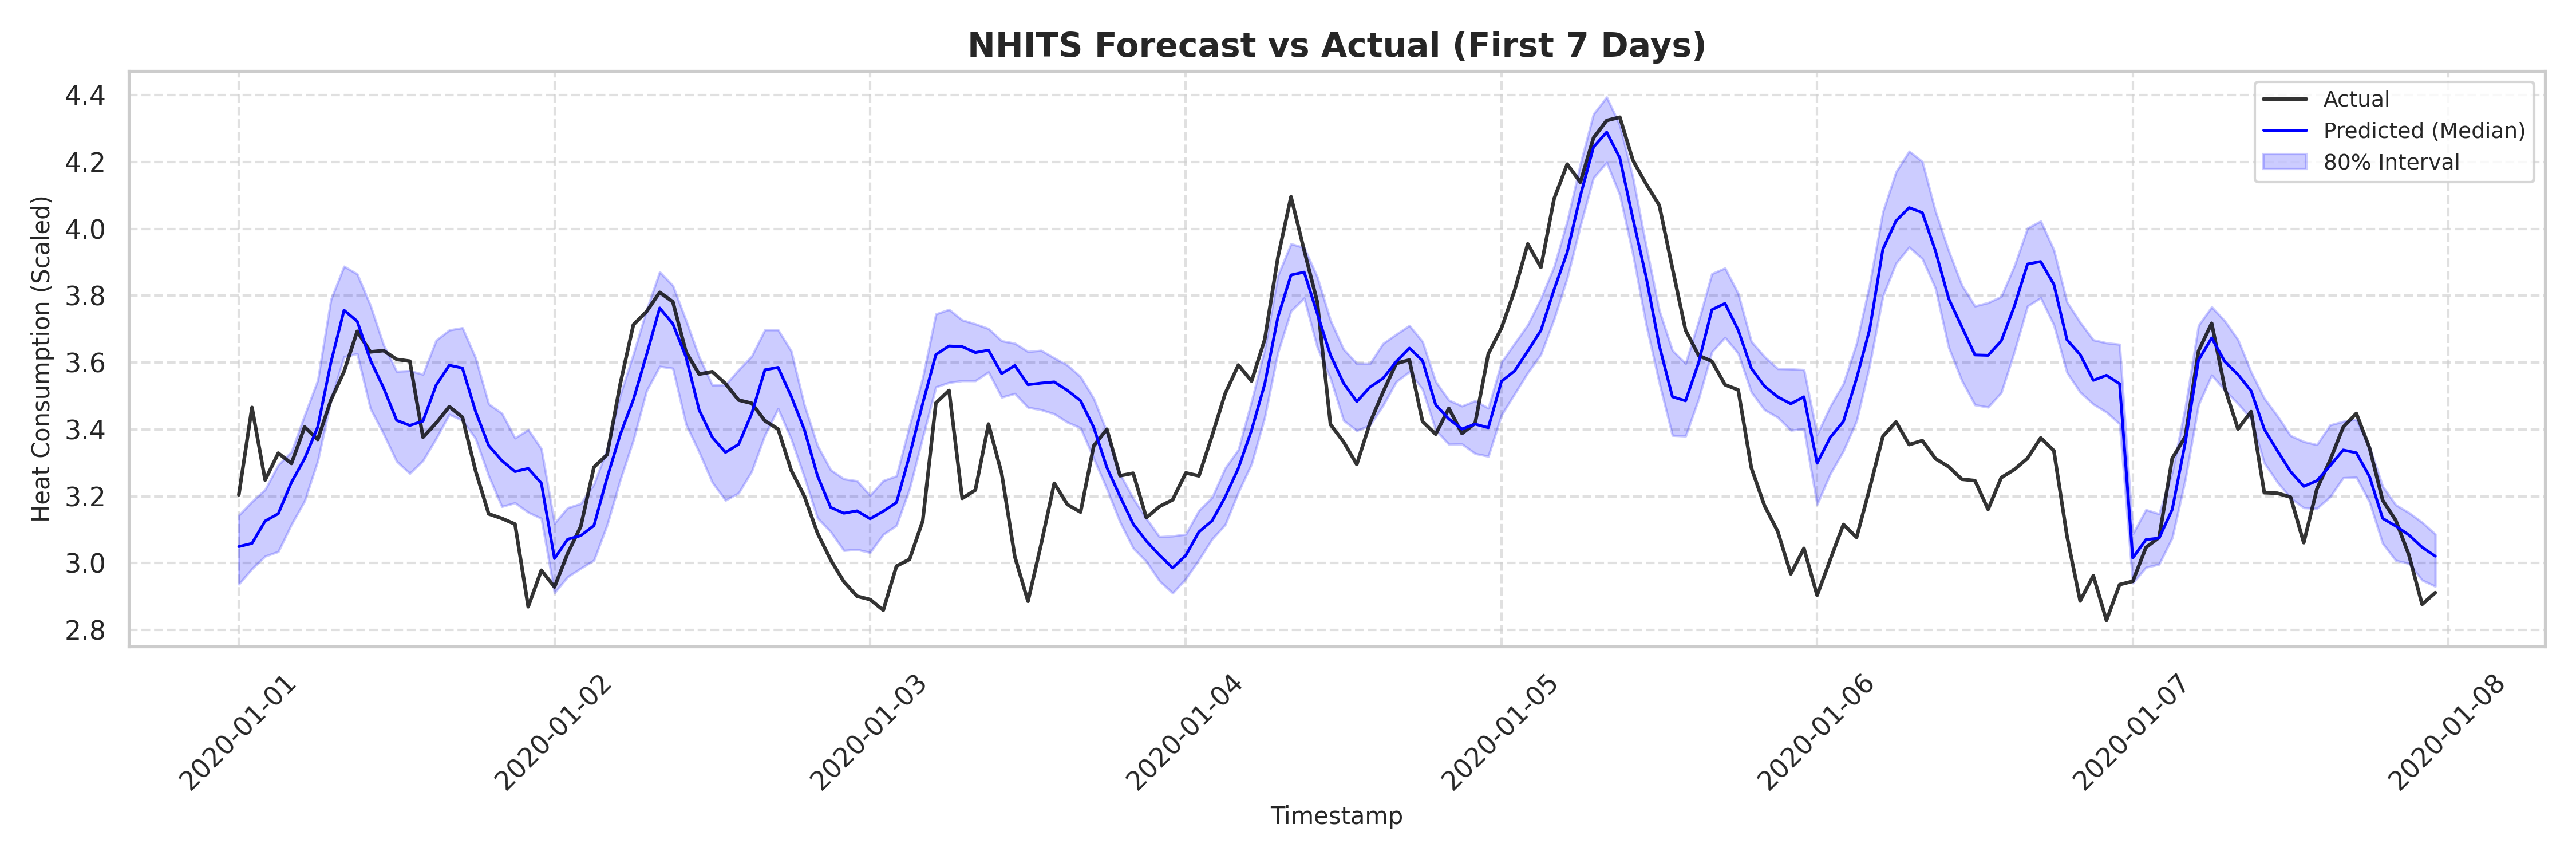


NHITS - Error Histogram


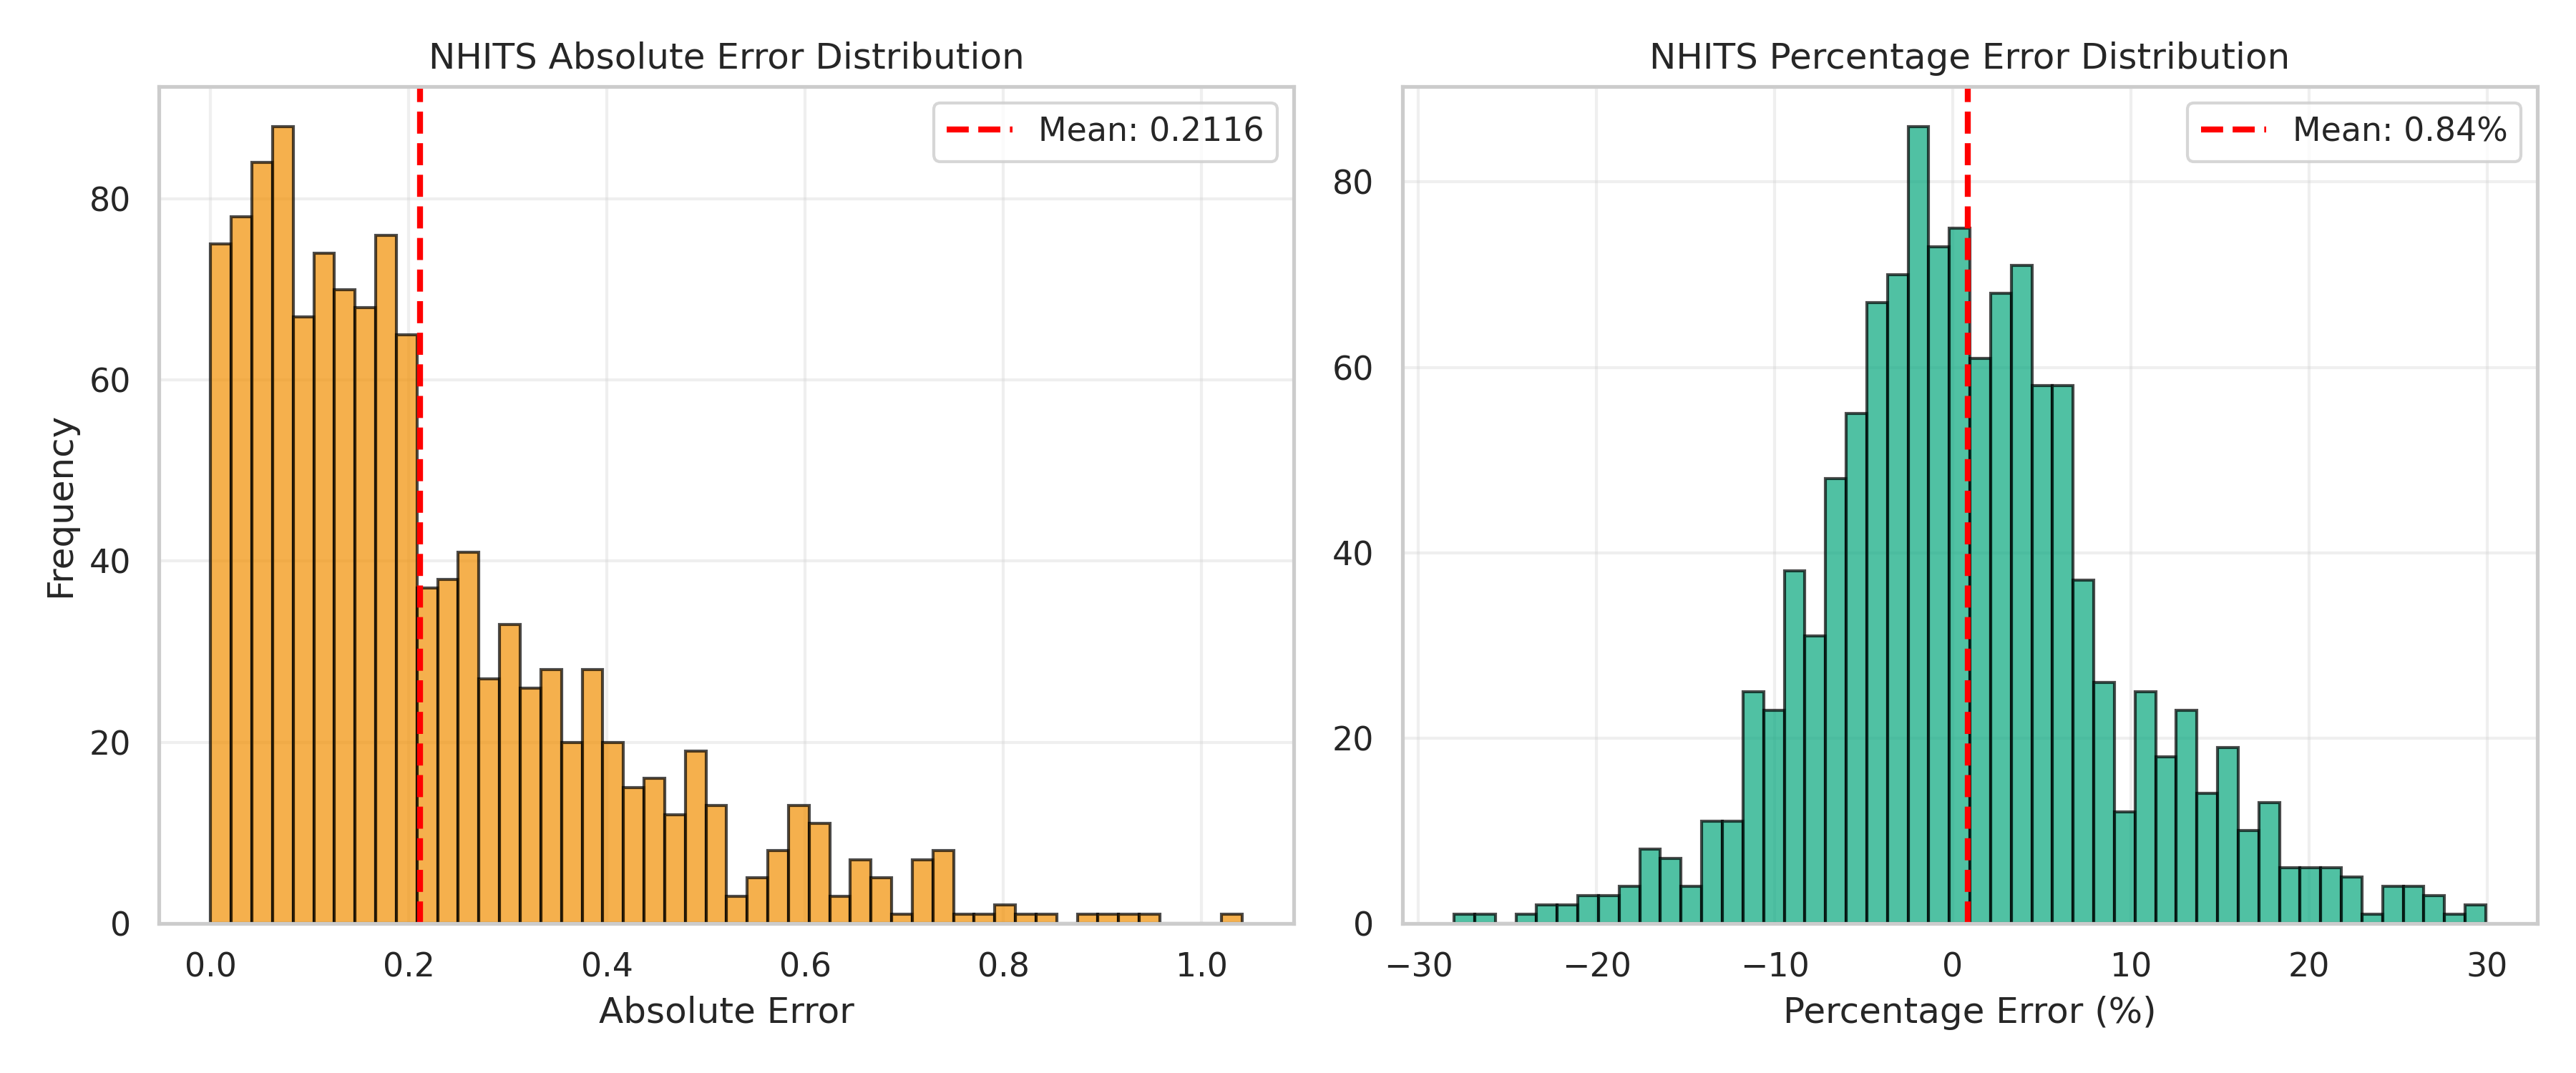


NHITS - Scatter Plot


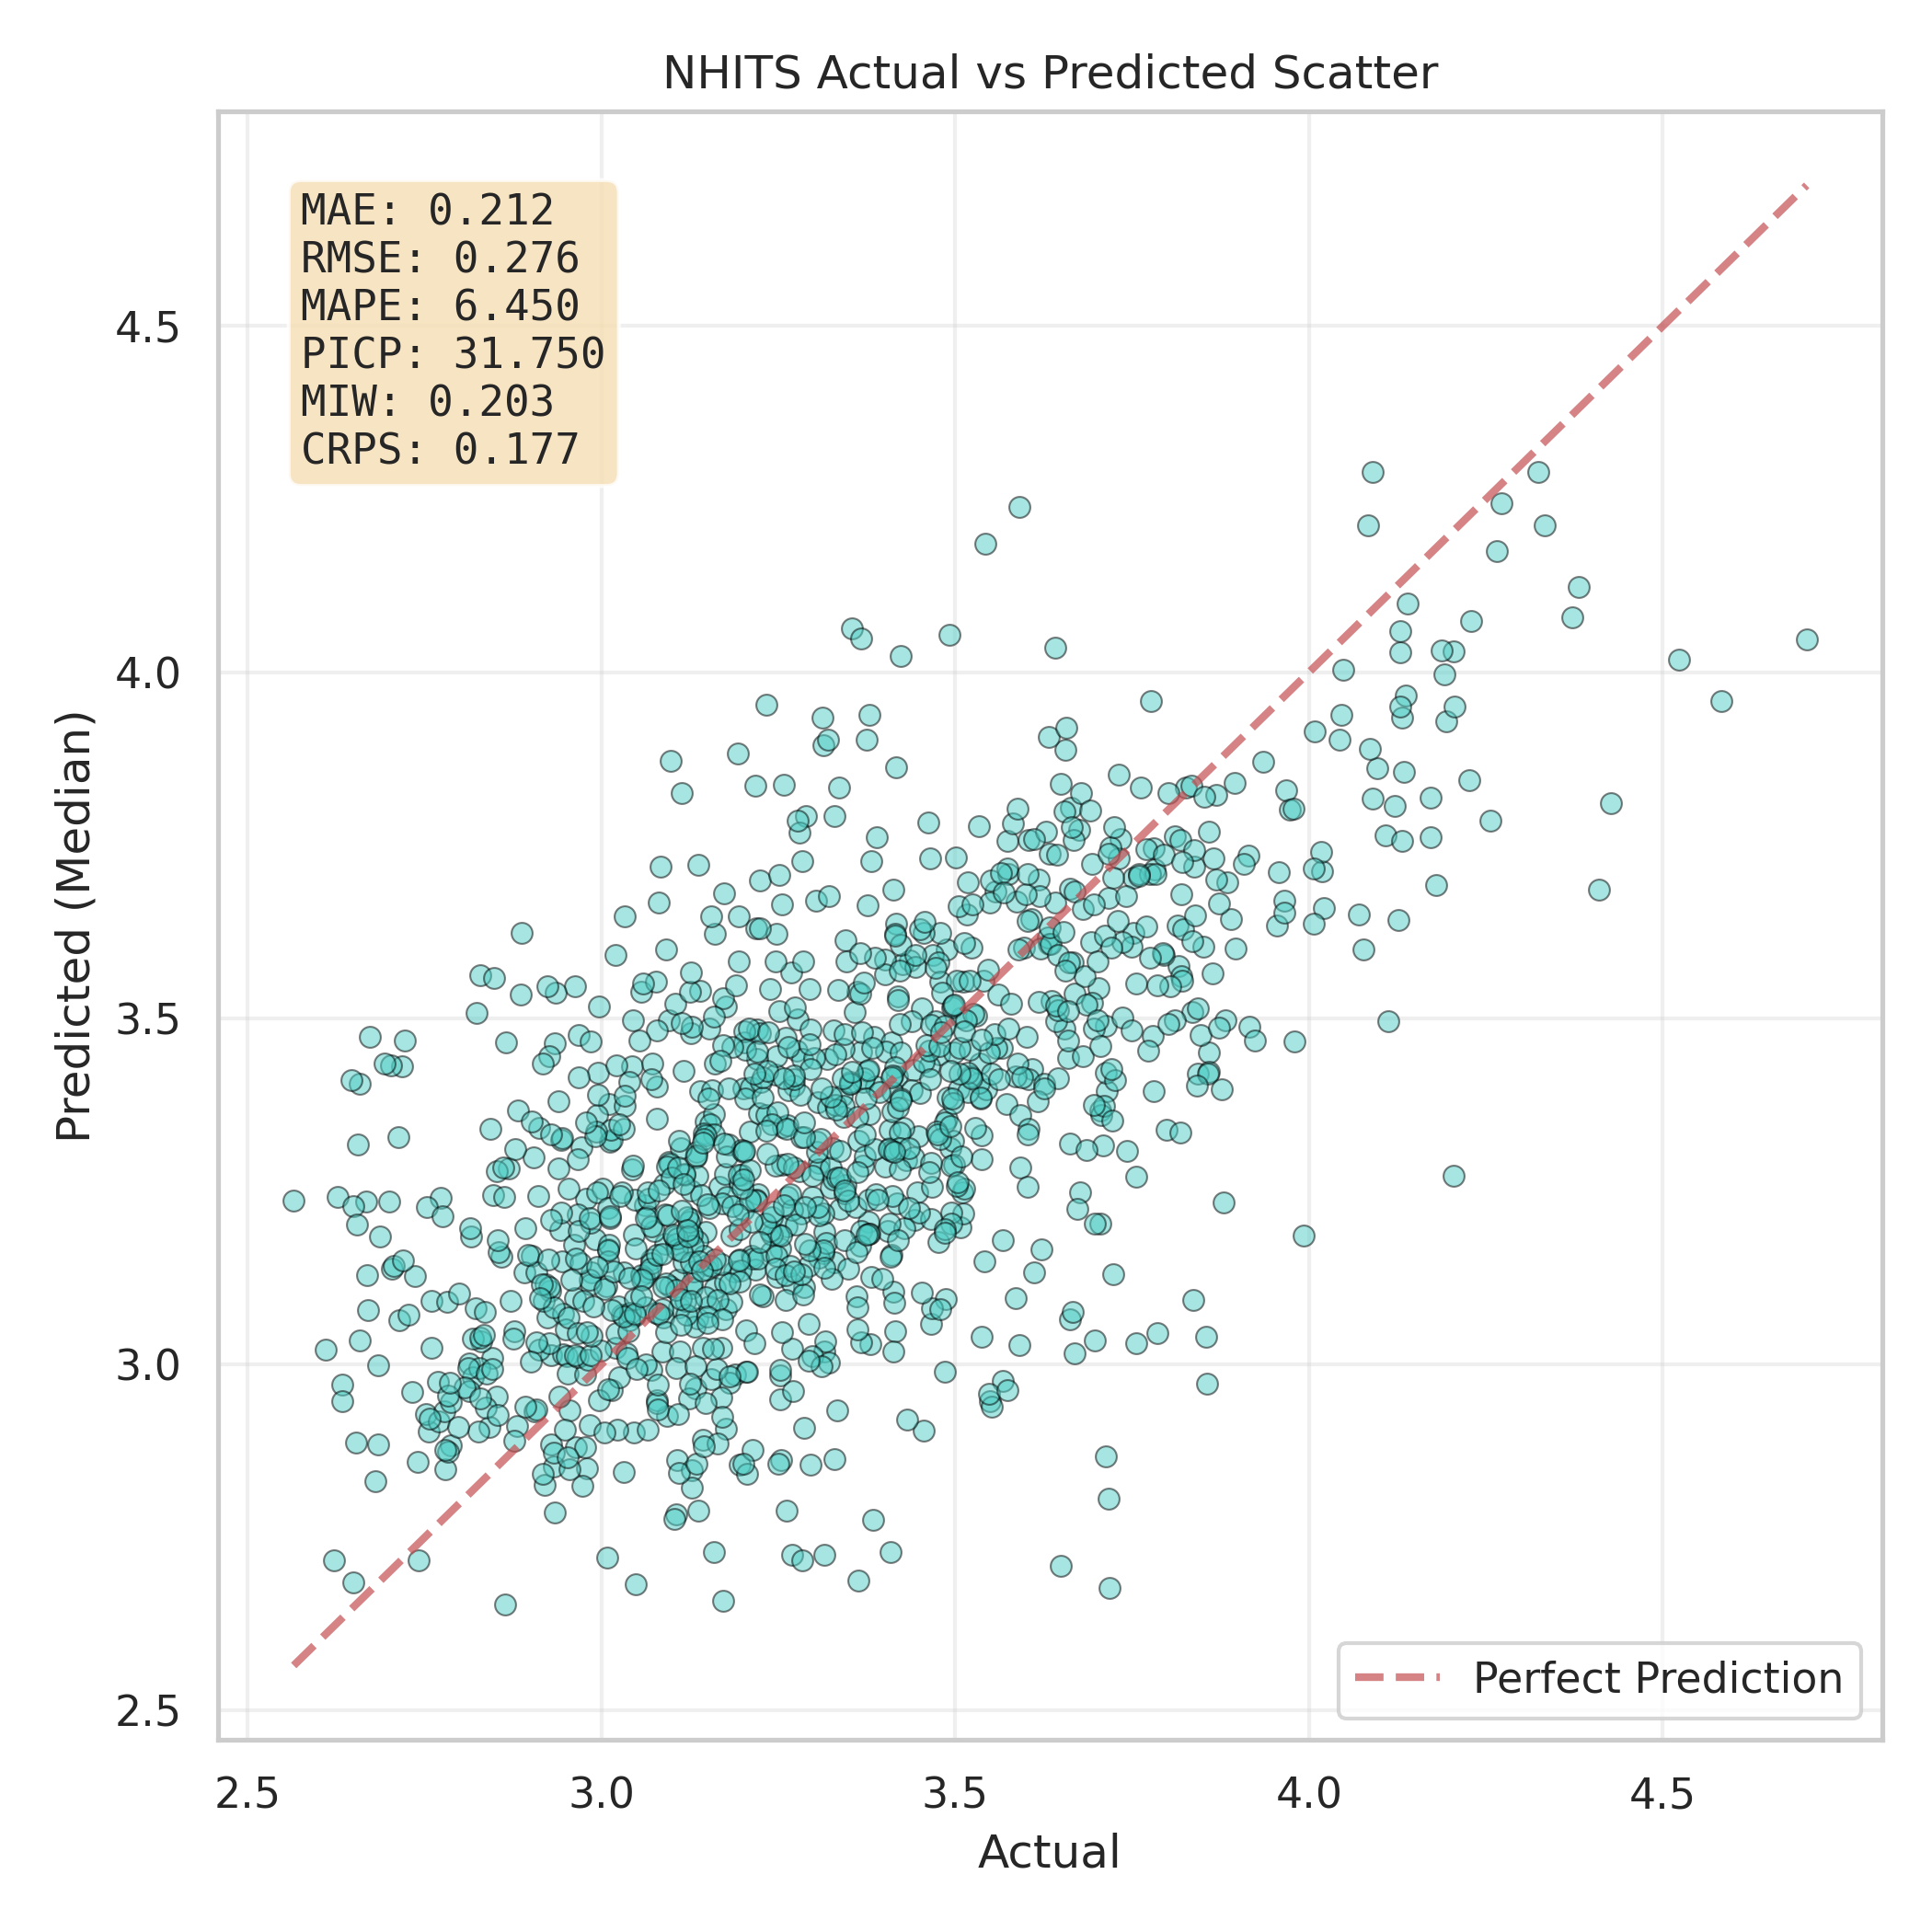

In [20]:
print("NHITS - Time Series Forecast")
nhits_ts = os.path.join(RESULTS_DIR, "nhits_timeseries.png")
if os.path.exists(nhits_ts):
    display(Image(filename=nhits_ts))

print("\nNHITS - Error Histogram")
nhits_err = os.path.join(RESULTS_DIR, "nhits_error_hist.png")
if os.path.exists(nhits_err):
    display(Image(filename=nhits_err))

print("\nNHITS - Scatter Plot")
nhits_scatter = os.path.join(RESULTS_DIR, "nhits_scatter.png")
if os.path.exists(nhits_scatter):
    display(Image(filename=nhits_scatter))

### 6.2 TimesNet Model Analysis

TimesNet - Time Series Forecast


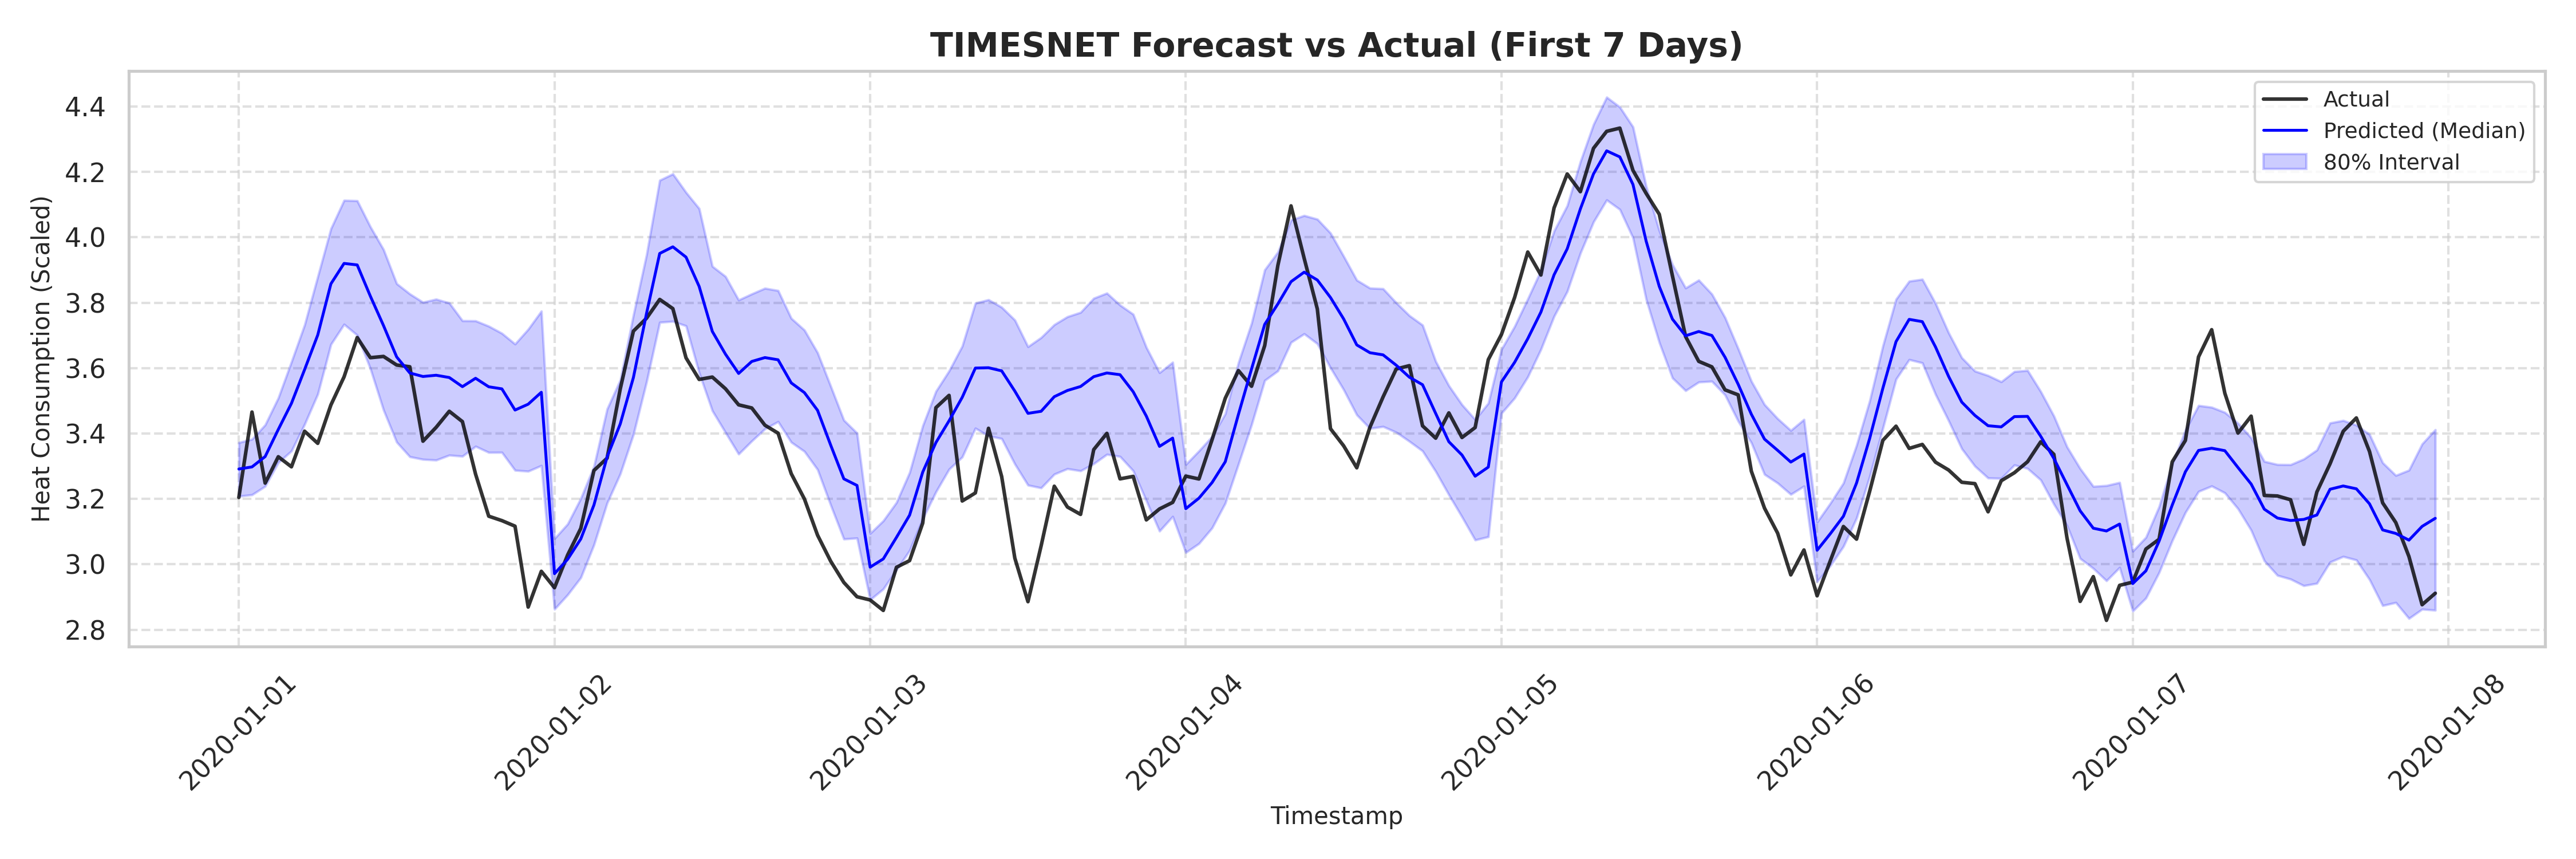


TimesNet - Error Histogram


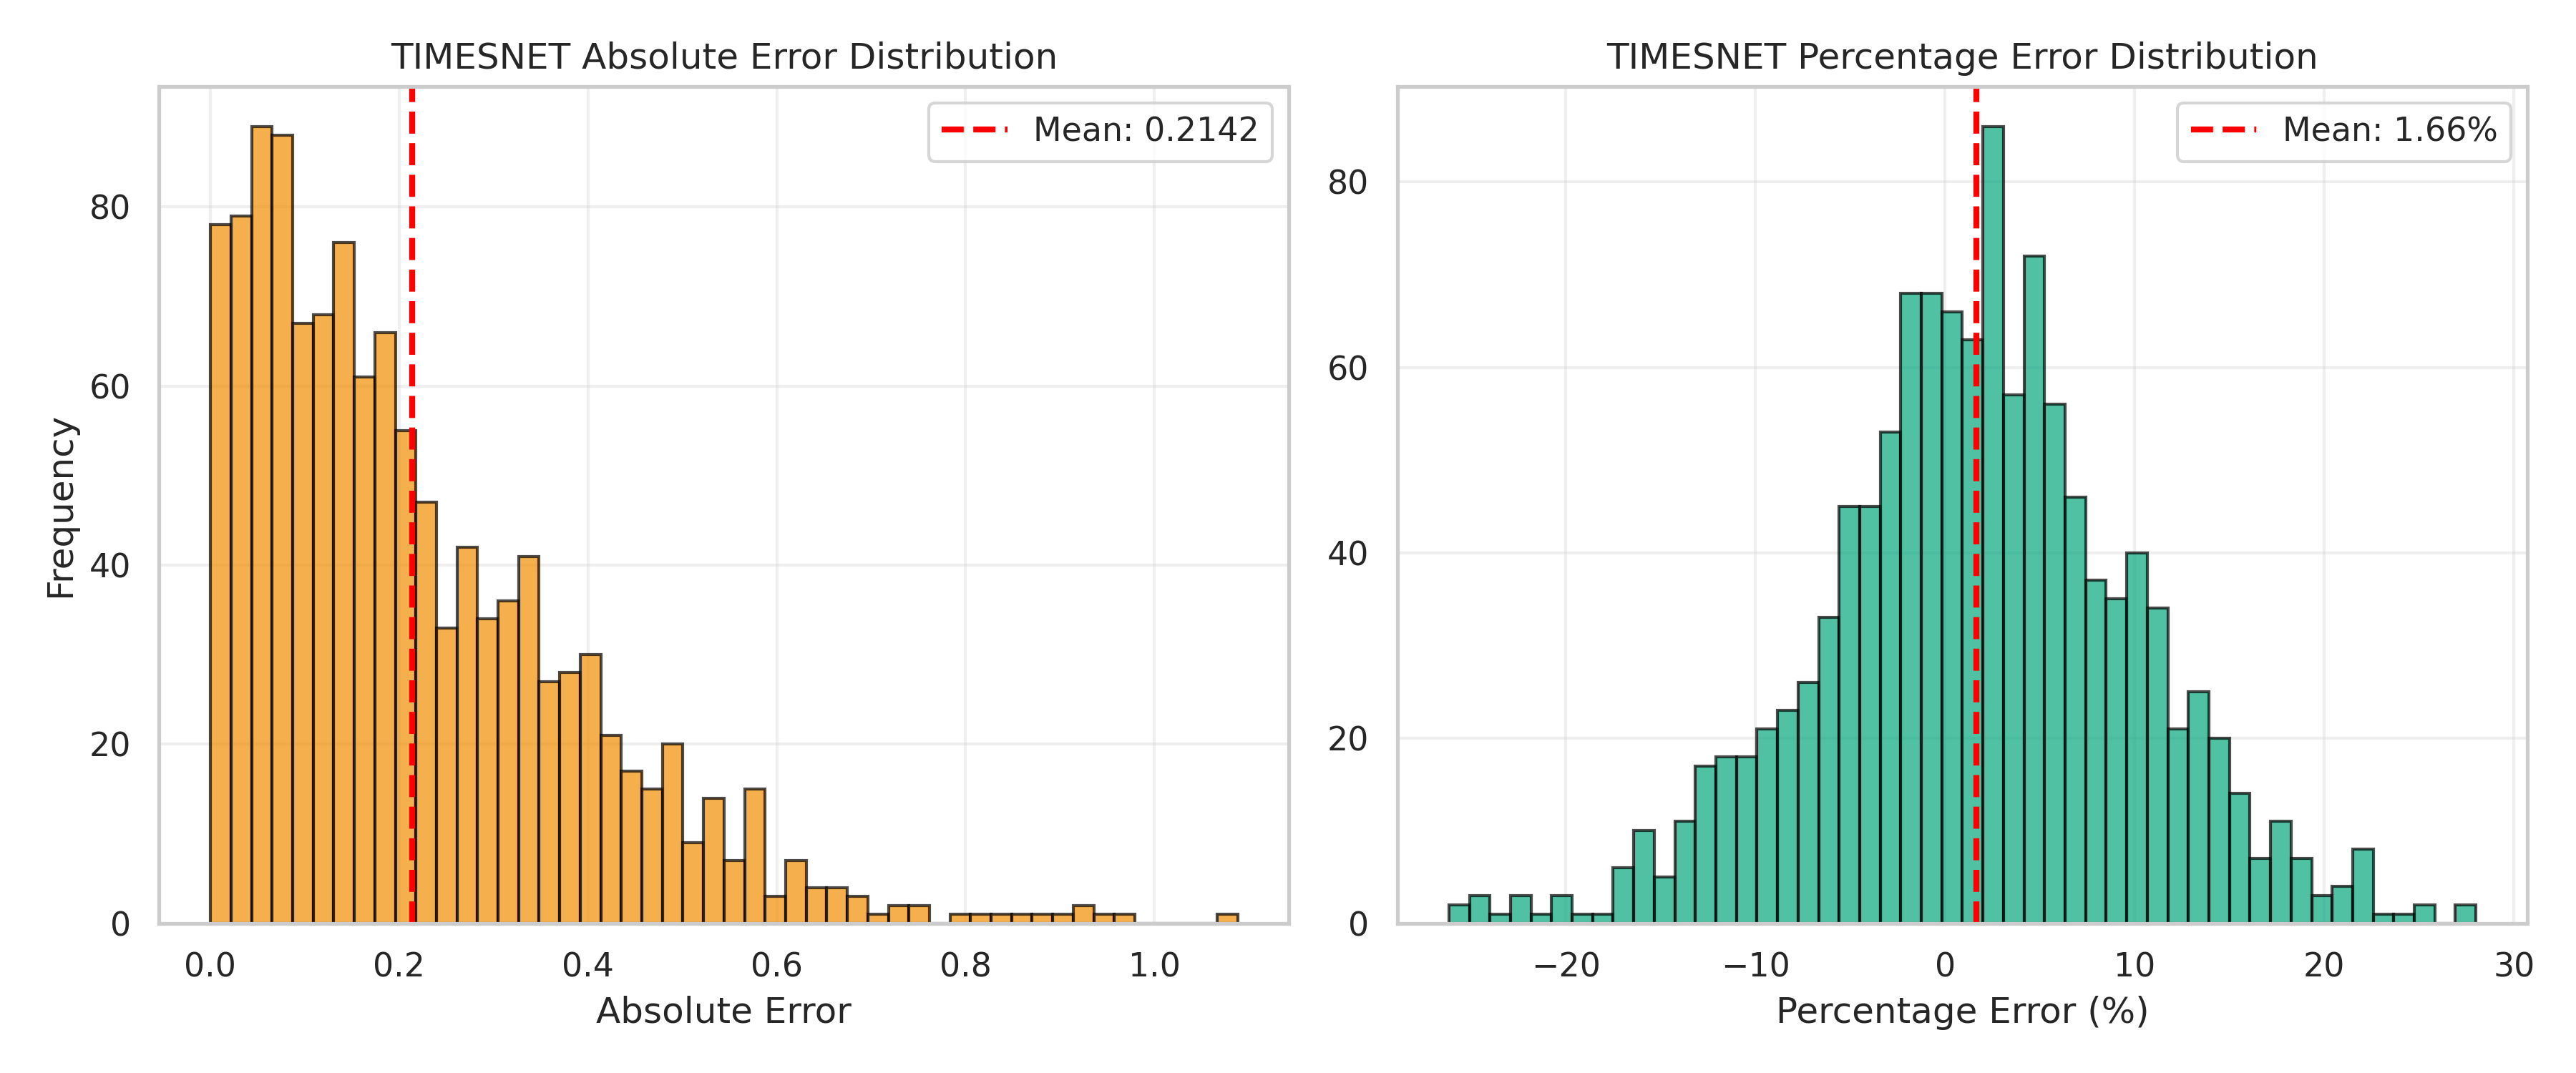


TimesNet - Scatter Plot


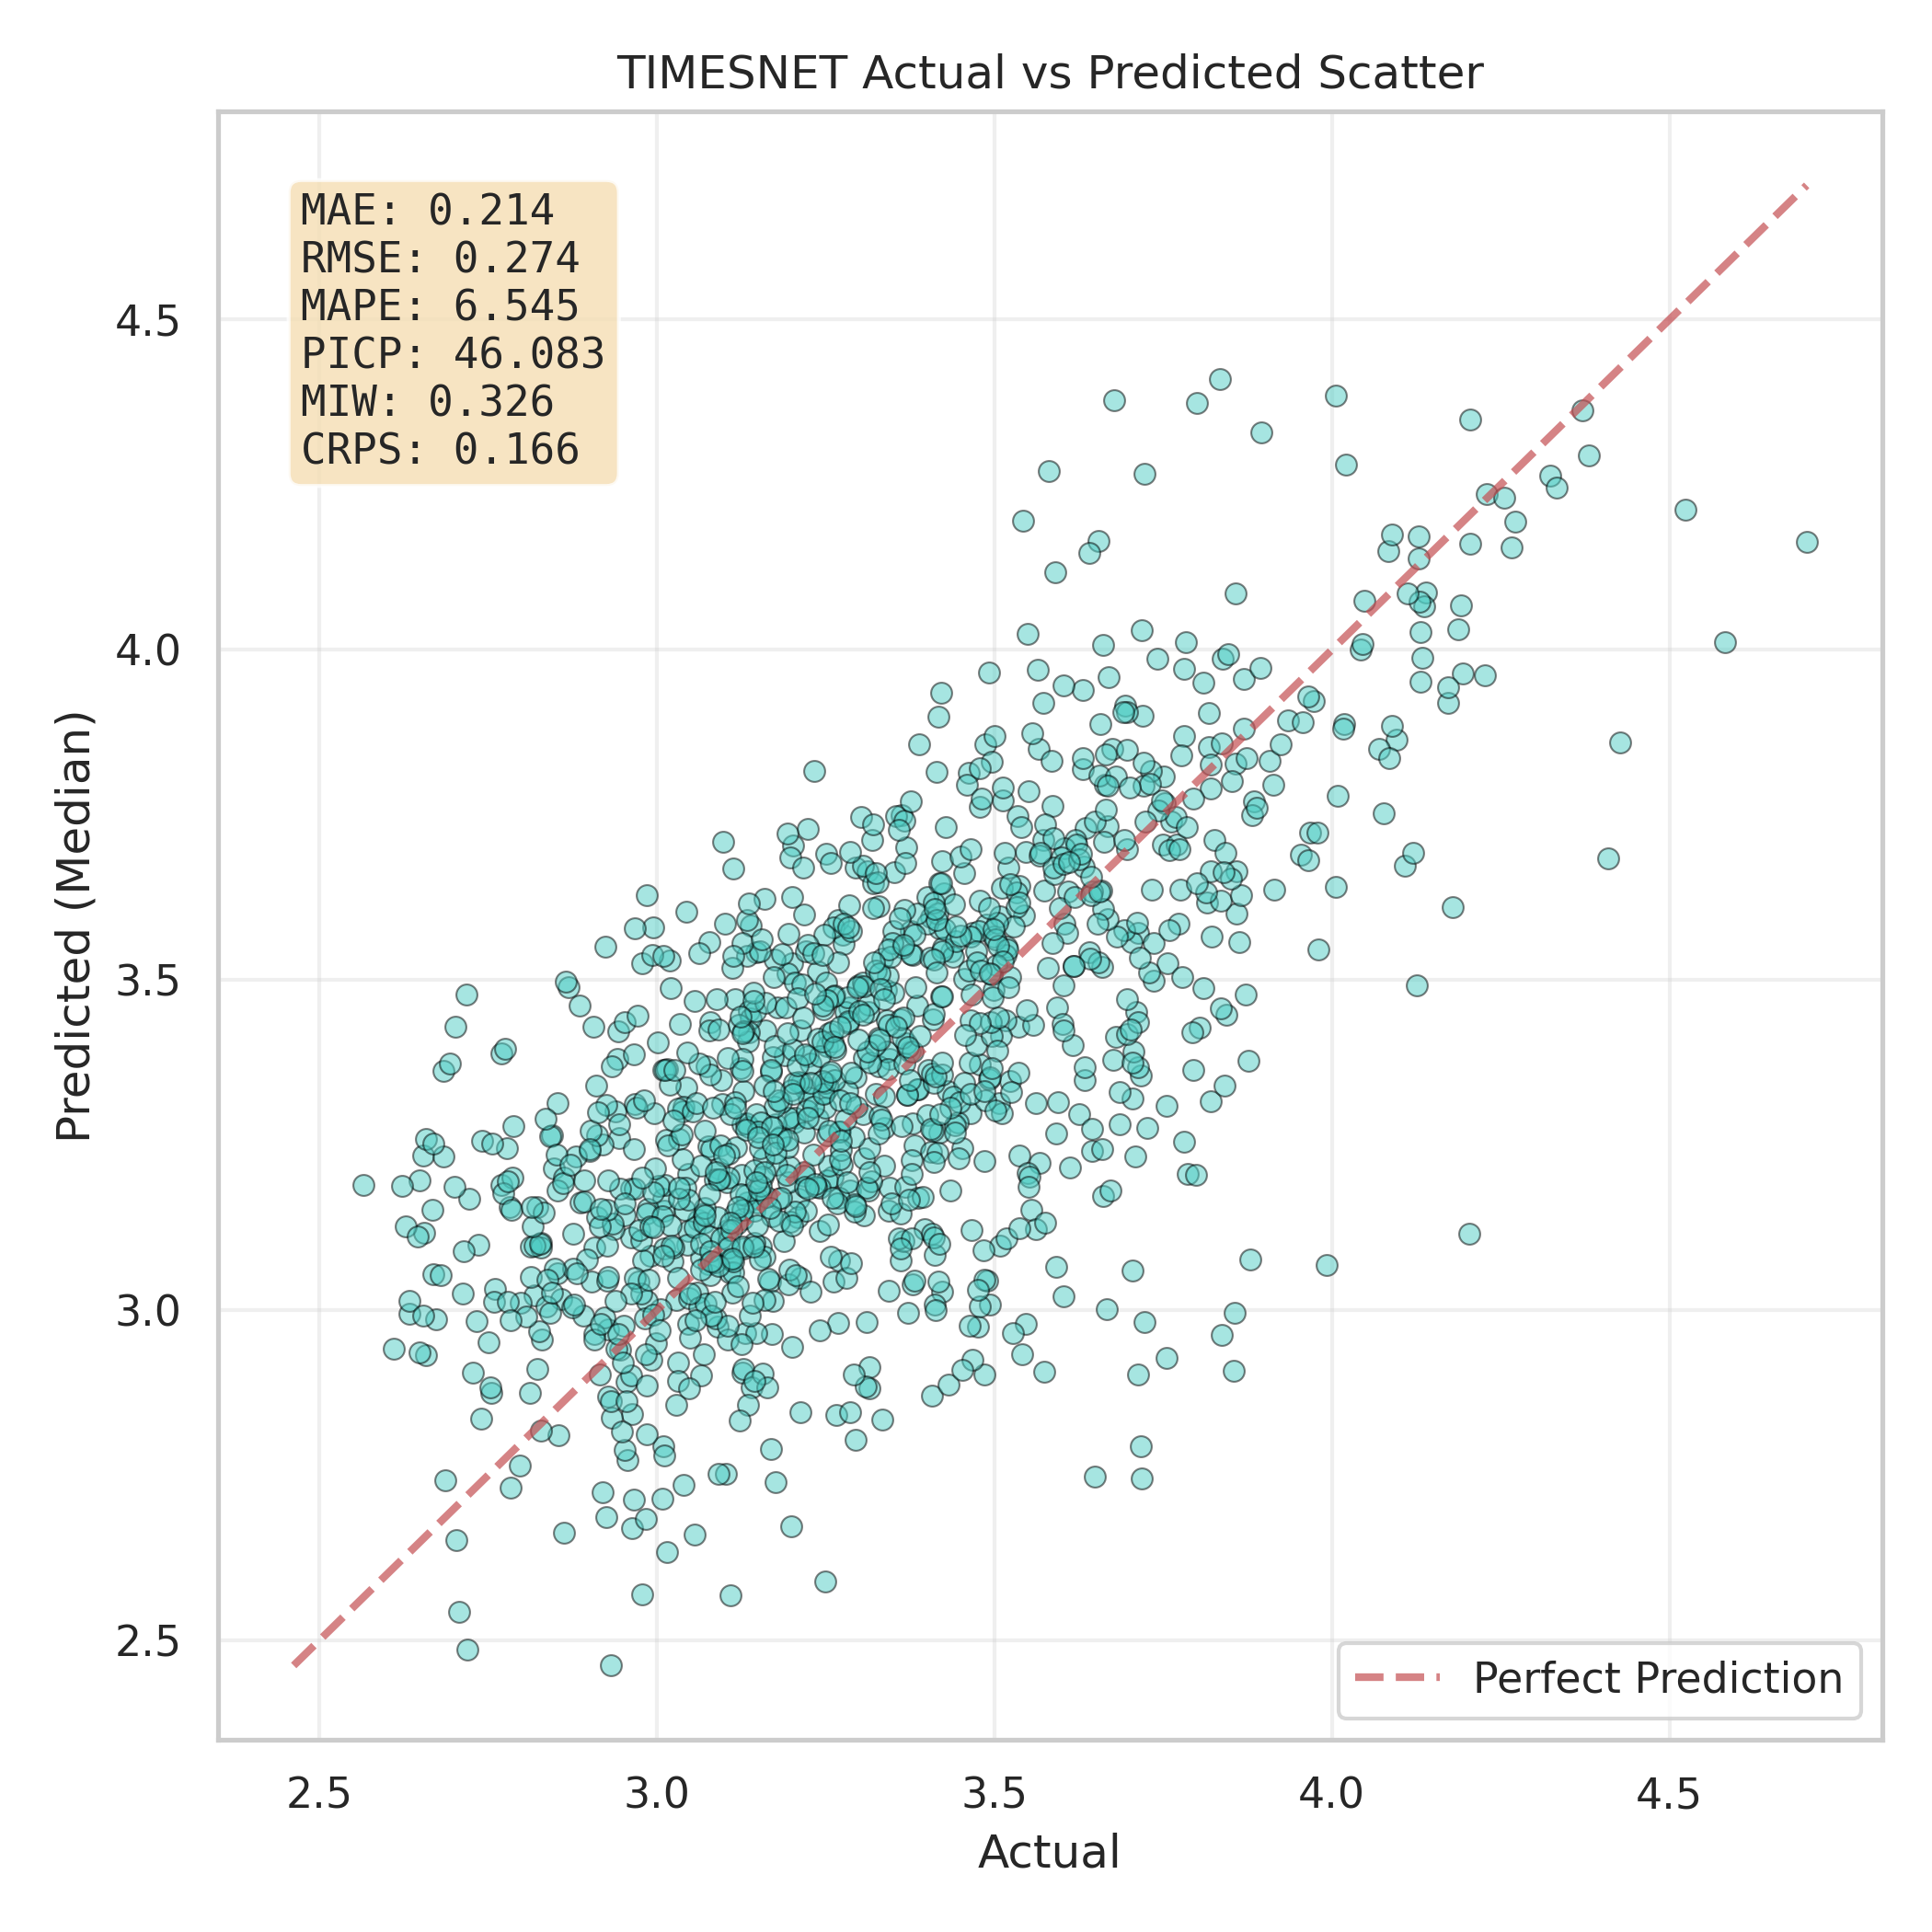

In [21]:
print("TimesNet - Time Series Forecast")
timesnet_ts = os.path.join(RESULTS_DIR, "timesnet_timeseries.png")
if os.path.exists(timesnet_ts):
    display(Image(filename=timesnet_ts))

print("\nTimesNet - Error Histogram")
timesnet_err = os.path.join(RESULTS_DIR, "timesnet_error_hist.png")
if os.path.exists(timesnet_err):
    display(Image(filename=timesnet_err))

print("\nTimesNet - Scatter Plot")
timesnet_scatter = os.path.join(RESULTS_DIR, "timesnet_scatter.png")
if os.path.exists(timesnet_scatter):
    display(Image(filename=timesnet_scatter))

## 7. Results Interpretation

### Key Findings:

In [14]:
# Calculate percentage differences
if not os.path.exists(os.path.join(RESULTS_DIR, "benchmark_results.csv")):
    print("❌ Cannot analyze results - benchmark hasn't been run yet!")
    print("   Please run cell 7 first.")
else:
    results_df = pd.read_csv(os.path.join(RESULTS_DIR, "benchmark_results.csv"))
    results_df_sorted = results_df.set_index('Model')
    
    if 'NHITS' not in results_df_sorted.index or 'TIMESNET' not in results_df_sorted.index:
        print("❌ Both models haven't been benchmarked yet!")
        print("   Current models in results:", list(results_df_sorted.index))
    else:
        nhits_metrics = results_df_sorted.loc['NHITS']
        timesnet_metrics = results_df_sorted.loc['TIMESNET']
        
        print("📈 Performance Analysis:")
        print("="*70)
        
        for metric in ['MAE', 'RMSE', 'MAPE', 'MIW', 'CRPS']:
            if metric in nhits_metrics and metric in timesnet_metrics:
                diff = ((timesnet_metrics[metric] - nhits_metrics[metric]) / nhits_metrics[metric]) * 100
                better = "NHITS" if diff > 0 else "TIMESNET"
                print(f"\n{metric}:")
                print(f"  NHITS    : {nhits_metrics[metric]:.4f}")
                print(f"  TimesNet : {timesnet_metrics[metric]:.4f}")
                print(f"  Difference: {abs(diff):.2f}% (better: {better})")
        
        # PICP analysis
        if 'PICP' in nhits_metrics and 'PICP' in timesnet_metrics:
            print(f"\nPICP (Coverage - target 80%):")
            print(f"  NHITS    : {nhits_metrics['PICP']:.2f}%")
            print(f"  TimesNet : {timesnet_metrics['PICP']:.2f}%")
            nhits_diff = abs(nhits_metrics['PICP'] - 80)
            timesnet_diff = abs(timesnet_metrics['PICP'] - 80)
            better = "NHITS" if nhits_diff < timesnet_diff else "TIMESNET"
            print(f"  Better calibrated: {better}")
        
        print("\n" + "="*70)

📈 Performance Analysis:

MAE:
  NHITS    : 0.2116
  TimesNet : 0.2142
  Difference: 1.22% (better: NHITS)

RMSE:
  NHITS    : 0.2764
  TimesNet : 0.2745
  Difference: 0.68% (better: TIMESNET)

MAPE:
  NHITS    : 6.4501
  TimesNet : 6.5454
  Difference: 1.48% (better: NHITS)

MIW:
  NHITS    : 0.2025
  TimesNet : 0.3255
  Difference: 60.73% (better: NHITS)

CRPS:
  NHITS    : 0.2190
  TimesNet : 0.1663
  Difference: 24.07% (better: TIMESNET)

PICP (Coverage - target 80%):
  NHITS    : 31.75%
  TimesNet : 46.08%
  Better calibrated: TIMESNET



## 8. Summary and Conclusions

This comprehensive benchmark compared NHITS and TimesNet for heat consumption forecasting:

**Metrics Evaluated:**
- **MAE/RMSE/MAPE**: Point forecast accuracy
- **CRPS**: Probabilistic forecast quality (lower is better)
- **PICP**: Prediction interval coverage (should be ~80% for 80% intervals)
- **MIW**: Mean interval width (narrower intervals are better if coverage is maintained)

**Model Characteristics:**
- **NHITS (Darts)**: Hierarchical temporal neural network with quantile regression
- **TimesNet (NeuralForecast)**: Temporal 2D-variation modeling with multi-horizon quantile loss

**Next Steps:**
- Review individual model plots for detailed error analysis
- Consider hyperparameter optimization if results need improvement
- Examine specific time periods where models differ significantly
- Check feature importance for model interpretability